# Sliding Window Approaches to Spectral Estimation

Aperiodic activity is known to fluctuate not only with brain state, but also likely exhibits event-related modulation. Time-resolved methods for spectral parameterization might be desirable for researchers investigating highly time-sensitive or event-related changes in aperiodic activity. 

### Issue

There are few easily accessible methods available for estimating aperiodic activity on an event-locked basis, with the notable exception of Spectral Parameterization Resolved in Time (SPRiNT), which is a Matlab-based package [see Wilson et al 2022].

### Solution

The SpecParam tool can be used to generate successive, windowed estimates of spectral parameters, which can then be analyzed in a similar manner as event-related periodic changes might be.

### Related Work

The following papers include discussion of this topic:

- [Time-resolved parameterization of aperiodic and periodic brain activity](https://elifesciences.org/articles/77348#abstract), Wilson et al, 2022

### Related Discussion / Examples

The following examples discuss related topics:
-  [LINK](LINK), DESCRIPTION

### Imports

In [1]:
# Imports
# Standard python libraries
import numpy as np
import scipy.io as sio
from scipy.signal.windows import hann
from scipy.fft import fft, fftfreq, rfft, rfftfreq

# Neurodsp libraries
from neurodsp import spectral

# SpecParam (FOOOF) libraries 
from fooof import FOOOF, FOOOFGroup
from fooof.analysis import get_band_peak_fm, get_band_peak_fg

# Plotting imports
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina' # high res plotting

### Load Data

In [2]:
# We are setting the sampling frequency here. The data is sampled at 1000 Hz.
fs = 1000 

# Load the channel and the event indices.
data = sio.loadmat('../data/ecog_data.mat', squeeze_me=True)
sta = data['sta'] # Standard event
tar = data['tar'] # Target event
resp = data['resp'] # Response times
data = data['data'] # Neural data from one ECoG channel
times = np.arange(len(data))/fs

### Inspect the raw data, PSD (<60 Hz), and initial FOOOF fit

In [3]:
# Get a sense of the shape of these arrays, and their content
print(data.shape)
print(tar.shape)
print(sta.shape)
print('\nFirst few target events: ', end='')
print(tar[:10])

(1459920,)
(117,)
(380,)

First few target events: [370021 373387 378106 381964 384115 398071 399946 406863 408338 411489]


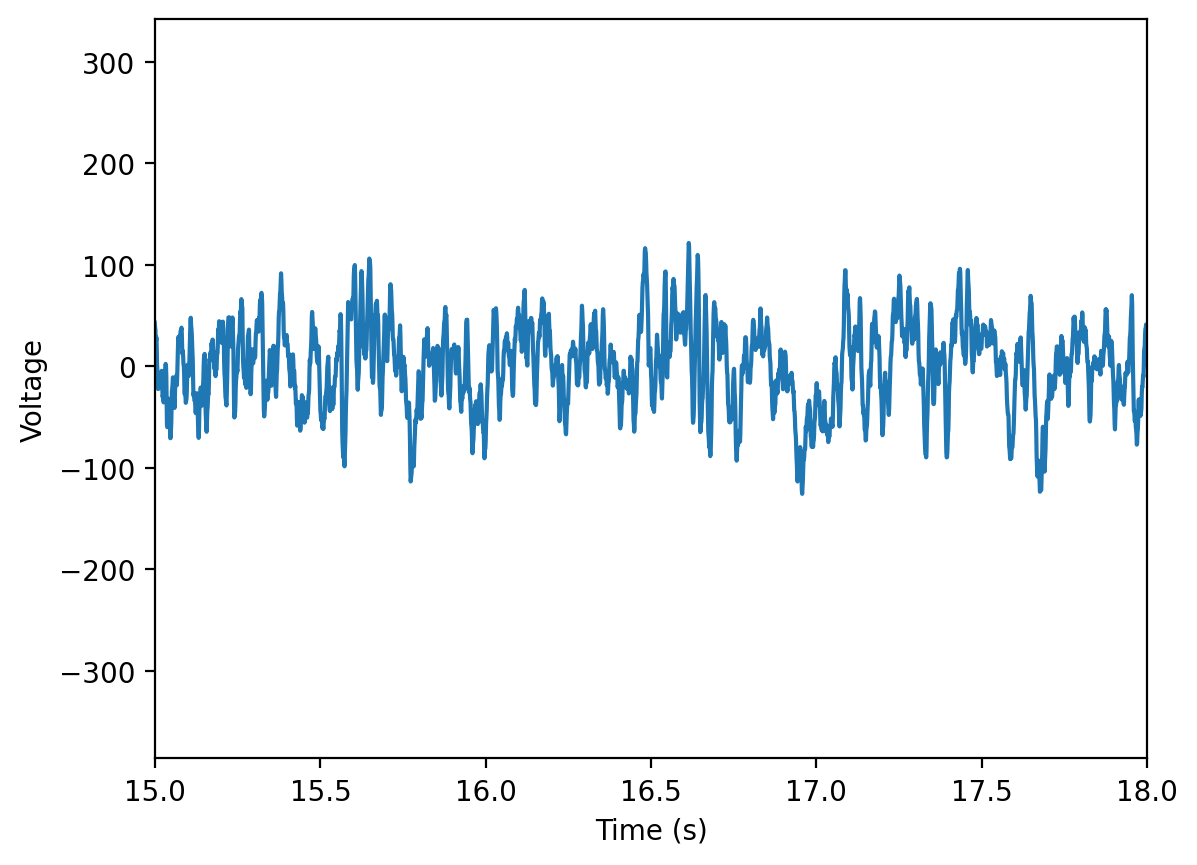

In [4]:
# Plot a section of the data in the time domain.
plt.plot(times, data)
plt.xlim((15,18))
plt.xlabel('Time (s)')
plt.ylabel('Voltage')
plt.show()

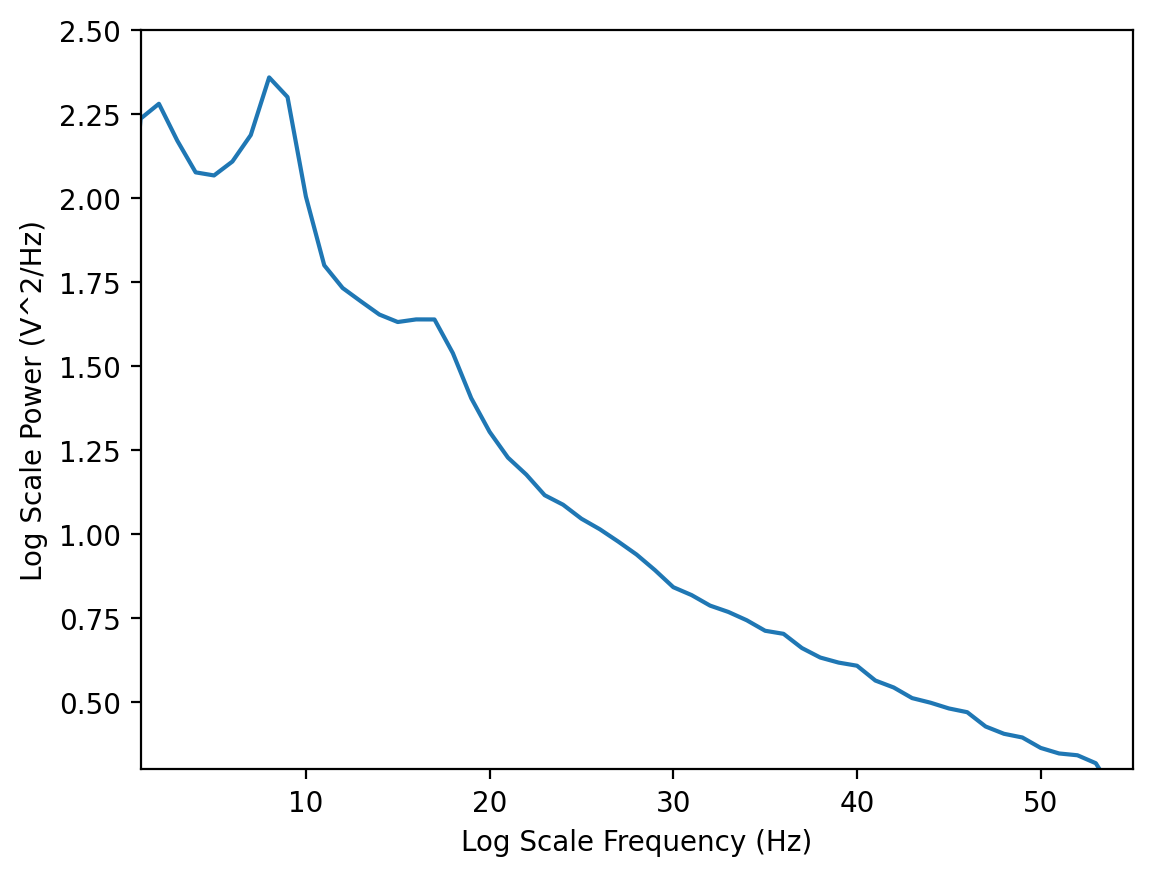

In [5]:
# Compute power spectrum
freq, psd = spectral.compute_spectrum(data, fs=fs, method='welch', window='hann')

# Plot with log scaling the power, zoom in below 60 Hz, and log scale the frequency axis
plt.plot(freq, np.log10(psd))
plt.xlabel('Log Scale Frequency (Hz)')
plt.ylabel('Log Scale Power (V^2/Hz)')
plt.xlim((1, 55))
plt.ylim((0.3, 2.5))
plt.show()

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                        The model was run on the frequency range 1 - 40 Hz                        
                                 Frequency Resolution is 1.00 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset, knee, exponent):                           
                                     4.6699, 287.0261, 2.5553                                     
                                                                                                  
                                       2 peaks were found:                                        
          

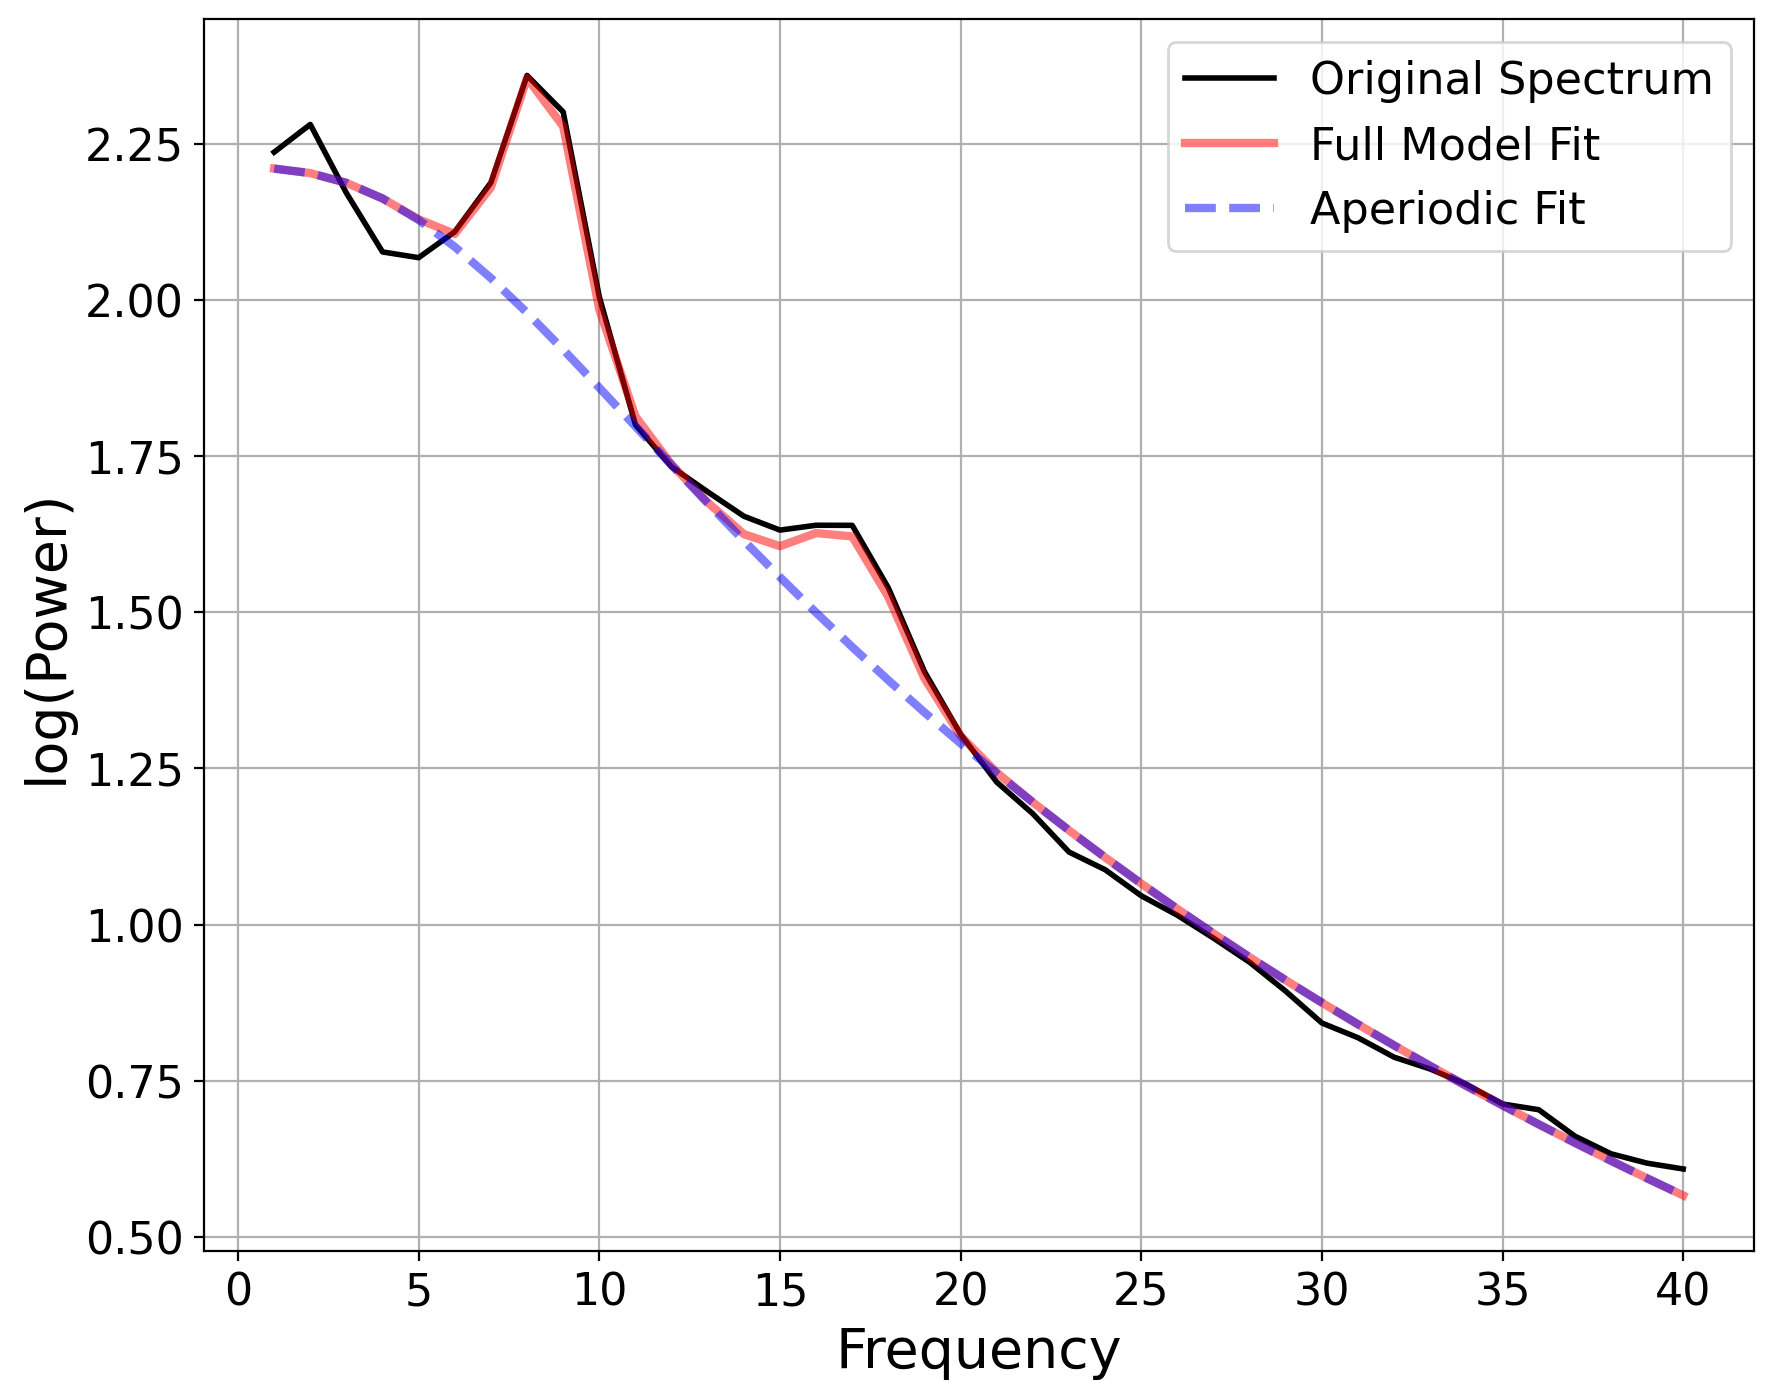

In [6]:
# In this case, we set a peak width limit to be higher than 2 frequencies wide AND smaller than 8 frequencies wide.
# Furthermore, we're setting a hard threshold minimum for the peak height to be considered an oscillation.
specparam_sets = {'peak_width_limits': [2, 8], 'min_peak_height': 0.1, 'aperiodic_mode':'knee'}
freq_range = [1, 40] # Depending on the quality of your data, you might not want to fit very high frequencies

# Define the frequency ranges you consider to be alpha oscillations
alpha_range = [8, 12]

# Initialize models
model = FOOOF(**specparam_sets)

# Fit models
model.fit(freq, psd, freq_range=freq_range)
model.report()

A spectral estimation across the whole length of the data yields us these three parameters describing the time-invariant aperiodic activity: an offset, an exponent, and a knee parameter. 

However, this dataset contains task-relevant events. In analyzing this data, you might want to know more about whether these parameters are modulated by task events, and if so, whether event-related aperiodic changes relate to behaviorally or cognitively interesting factors (as is typical in periodic analyses). 

One way to do so would be to select one time window prior to the stimulus onset, and another time window after stimulus onset, and compare the parameters between these. The details and implementation of this method is outlined in another notebook in this repository (XX-- fill in name of notebook that Andrew is working on).

An alternative method yields higher temporal resolution of event-locked aperiodic changes that may be obscured by computing spectral power over one large time window, or by trial-averaging in the time domain prior to aperiodic model fitting. To get time-resolved estimations of spectral parameters, we can use a sliding window approach to estimating and fitting aperiodic activity. This entails selecting out windows of time, deriving an aperiodic model fit, and sliding forward in time to repeat the process-- the end result being an array of aperiodic parameters calculated at N sequential time points. 

### Deriving Sliding Window Aperiodic Model Fits

First, let's define a window of time around the event onset which we will subselect our data from

In [7]:
time_around_event = (-2000,2000) # in ms

Next, let's define the length of the time window that we are sliding across the data, as well as the overlap between successive windows

In [8]:
len_win = 1000 # in ms
t_overlap = 500 # in ms

The choice in window length is not arbitrary; factors that influence the specific window of choice include the desired frequency range of interest, the timing of the task events themselves, and the total length of the task epoch that you are sliding across. 

For analyses dependent on accurate estimates of low frequency activity, you might want to use longer time windows. The lower bounds of the frequencies that you can estimate will be constrained by the length of your time window (as is true in any spectral estimation). For example, if you are interested in 2Hz (delta range) activity, you need at least two seconds of data to resolve a maximum of one delta cycle. Examples of analyses where low frequency activity as it is captured by the aperiodic signal might be particularly interesting include analyses focused on neural timescales, or for the aperiodic correction of low frequency oscillations. 

Other analyses might allow or even necessitate shorter time windows; for example if your task event is very brief, it may blur aperiodic changes in the time domain too much to have long or highly overlapping time windows. 

Now that we've selected our time window bounds, let's construct a function that will extract "trials" of event data.

In [9]:
def event_related(data, fs, indices, window, subtract_mean=None):
    """Take an input time series, vector of event indices, and window sizes,
    and return a 2d matrix of windowed trials around the event indices.
    
    Parameters
    ----------
    data : array-like 1d
        Voltage time series
    data : float
        Data sampling rate (Hz)
    indices : array-like 1d of integers
        Indices of event onset indices
    window : tuple (intengers)
        Window (in ms) around event onsets
    subtract_mean : tuple (intengers), optional
        if present, subtract the mean value in the subtract_mean window for each
        trial from that trial's time series (this is a trial-by-trial baseline)
    
    Returns
    -------
    event_related_matrix : array-like 2d
        Event-related times series around each index
        Each row is a separate event
    """
    
    # convert times (in ms) to indices of points along the array
    def windows_to_indices(fs, window_times):
        conversion_factor = (1/fs)*1000 # convert from time points to ms
        window_times = np.floor(np.asarray(window_times)/conversion_factor) # convert
        window_times = window_times.astype(int) # turn to ints
        
        return window_times
    
    window_idx = windows_to_indices(fs, window) # convert times (in ms) to indices
    inds = indices + np.arange(window_idx[0],window_idx[1])[:,None] # build matrix of indices
    event_times = np.arange(window[0], window[1], fs/1000)
    
    event_related_matrix = data[inds] # grab the data
    event_related_matrix = np.squeeze(event_related_matrix).T # make sure it's in the right format
    
    # baseline, if requested
    if subtract_mean is not None:
        basewin = [0,0]
        basewin[0] = np.argmin(np.abs(event_times-subtract_mean[0]))
        basewin[1] = np.argmin(np.abs(event_times-subtract_mean[1]))
        event_related_matrix = event_related_matrix - event_related_matrix[:, basewin[0]:basewin[1]].mean(axis=1, keepdims=True)
    
    return event_times, event_related_matrix

(For now, we will collapse across task condition)

In [10]:
event_times, event_related_matrix = event_related(data, fs, indices=np.concatenate([tar,sta]), window=(time_around_event), subtract_mean=(time_around_event[0],0))

print(event_times.shape)
print(event_related_matrix.shape)

(4000,)
(497, 4000)


In [11]:
event_times.shape

(4000,)

Let's visualize that ERP!

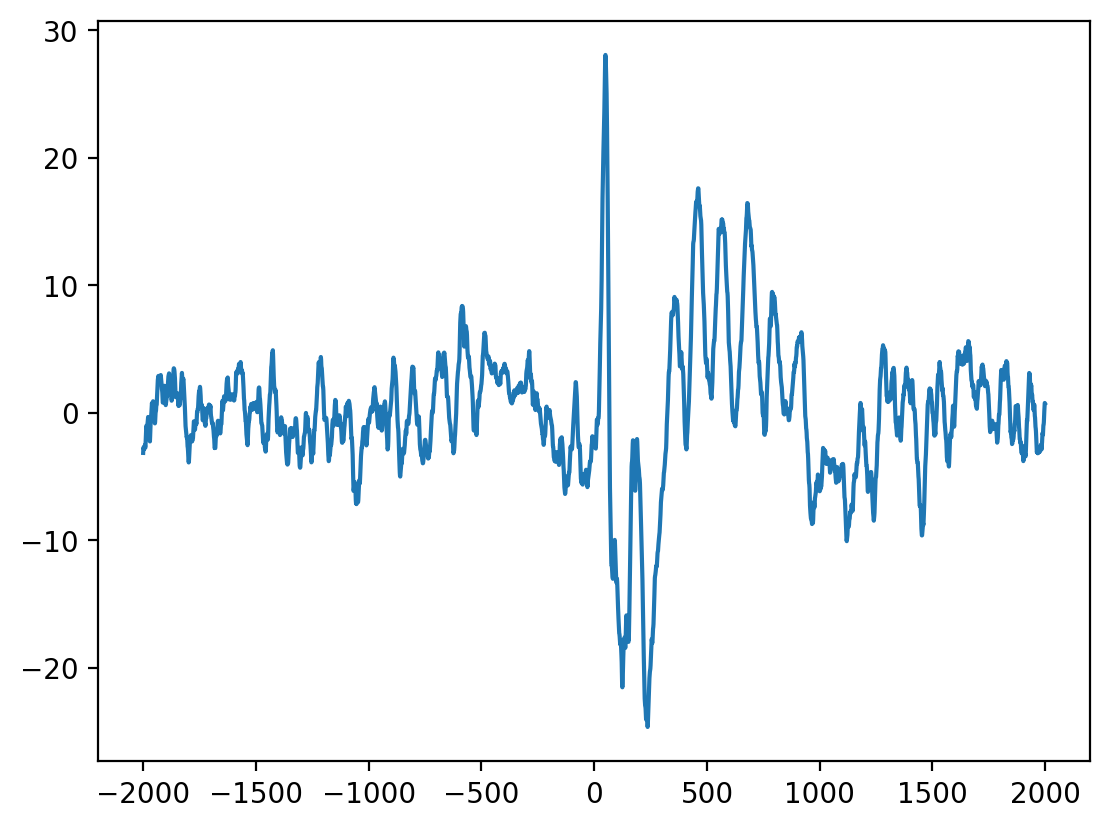

In [12]:
plt.plot(event_times, event_related_matrix.mean(axis=0))

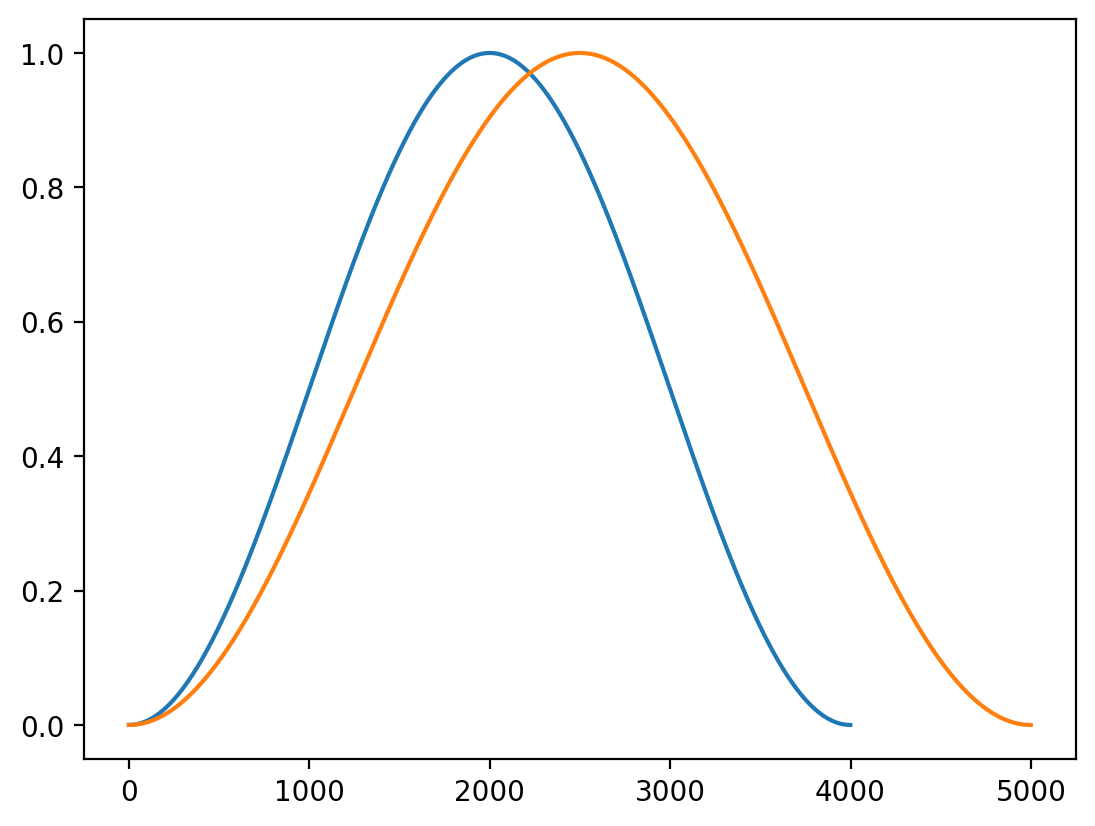

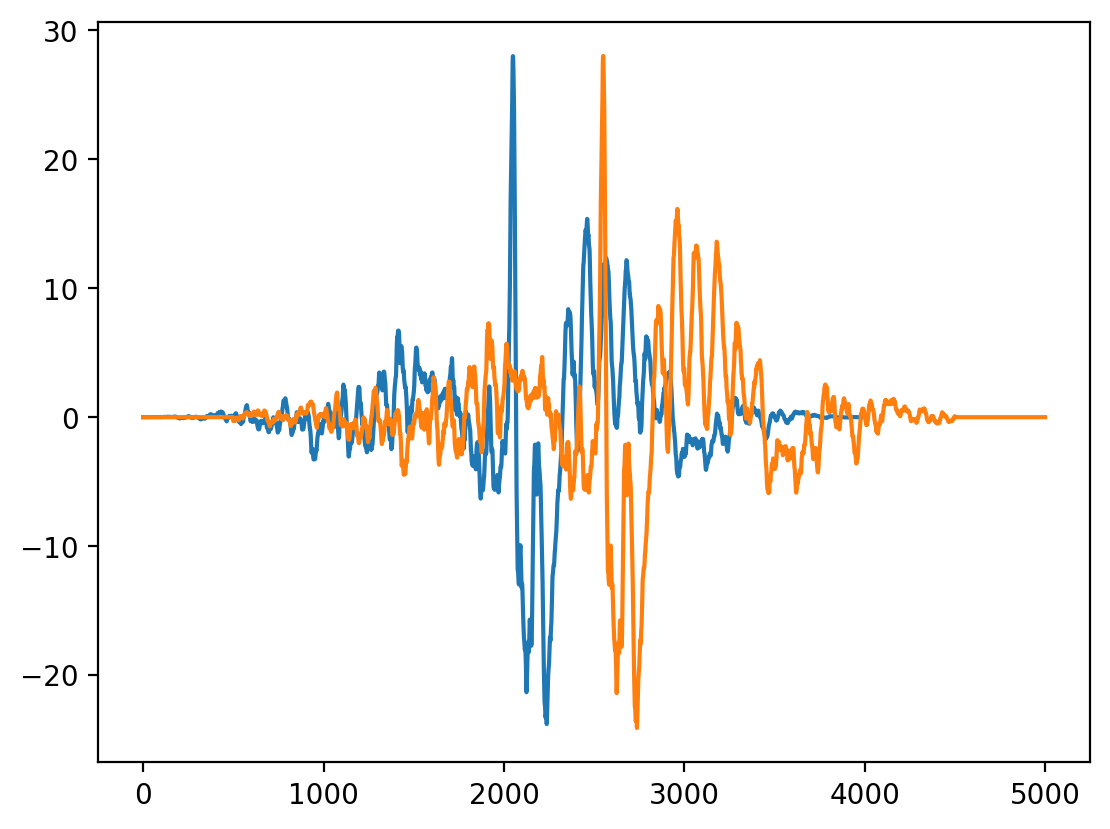

In [13]:
ex = event_related_matrix.mean(axis=0)
padding = 500
ex_zp = np.hstack((np.zeros(padding),ex,np.zeros(padding)))

window_func = hann(len(ex))
window_func_zp = hann(len(ex_zp))
convolved = window_func*ex
convolved_zp = window_func_zp*ex_zp
p = rfft(convolved)#, n=len(ex)+3000)
p_zp =  rfft(convolved_zp)
f = rfftfreq(len(ex), d= (1/fs))
f_zp =  rfftfreq(len(ex_zp), d= (1/fs))

plt.plot(window_func)
plt.plot(window_func_zp)
plt.show()
plt.plot(convolved)
plt.plot(convolved_zp)

In [14]:
f

array([0.0000e+00, 2.5000e-01, 5.0000e-01, ..., 4.9950e+02, 4.9975e+02,
       5.0000e+02])

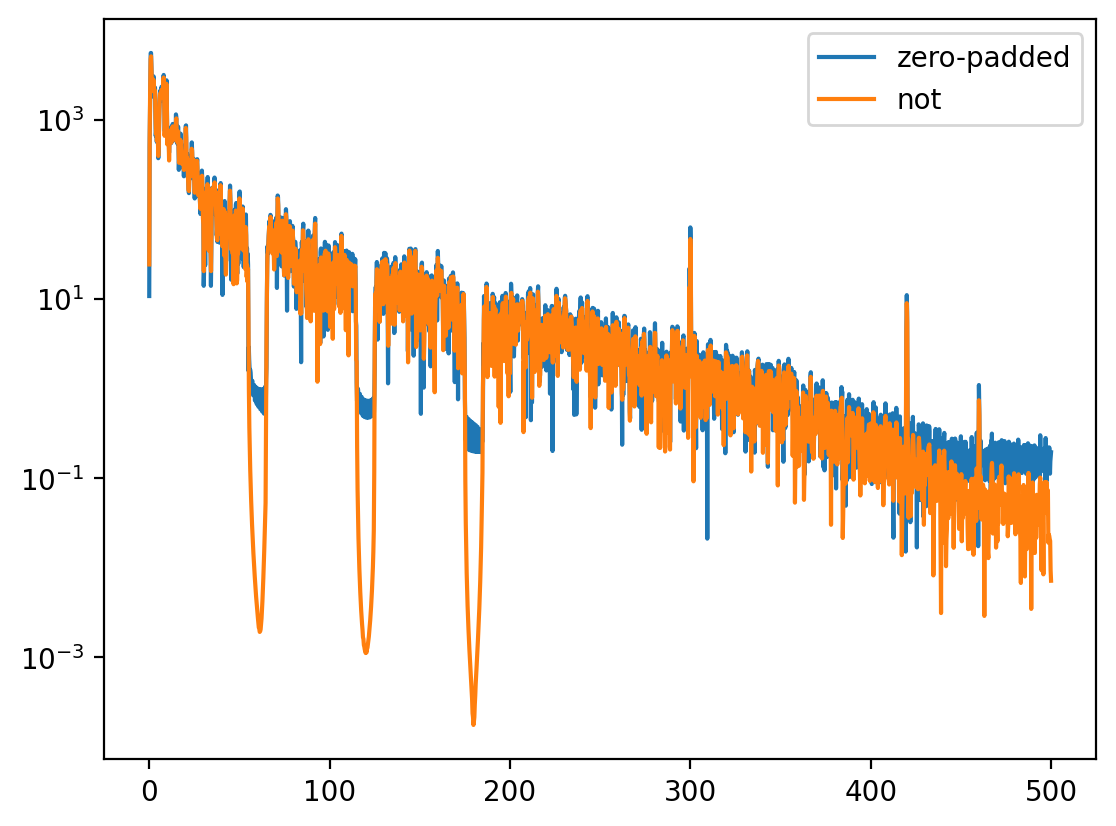

In [15]:

plt.semilogy(f_zp,np.abs(p_zp), label='zero-padded')
plt.semilogy(f,np.abs(p),label='not')
plt.legend()

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                        The model was run on the frequency range 1 - 40 Hz                        
                                 Frequency Resolution is 0.25 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset, knee, exponent):                           
                                    7.8255, 68666.7724, 3.9225                                    
                                                                                                  
                                       3 peaks were found:                                        
          

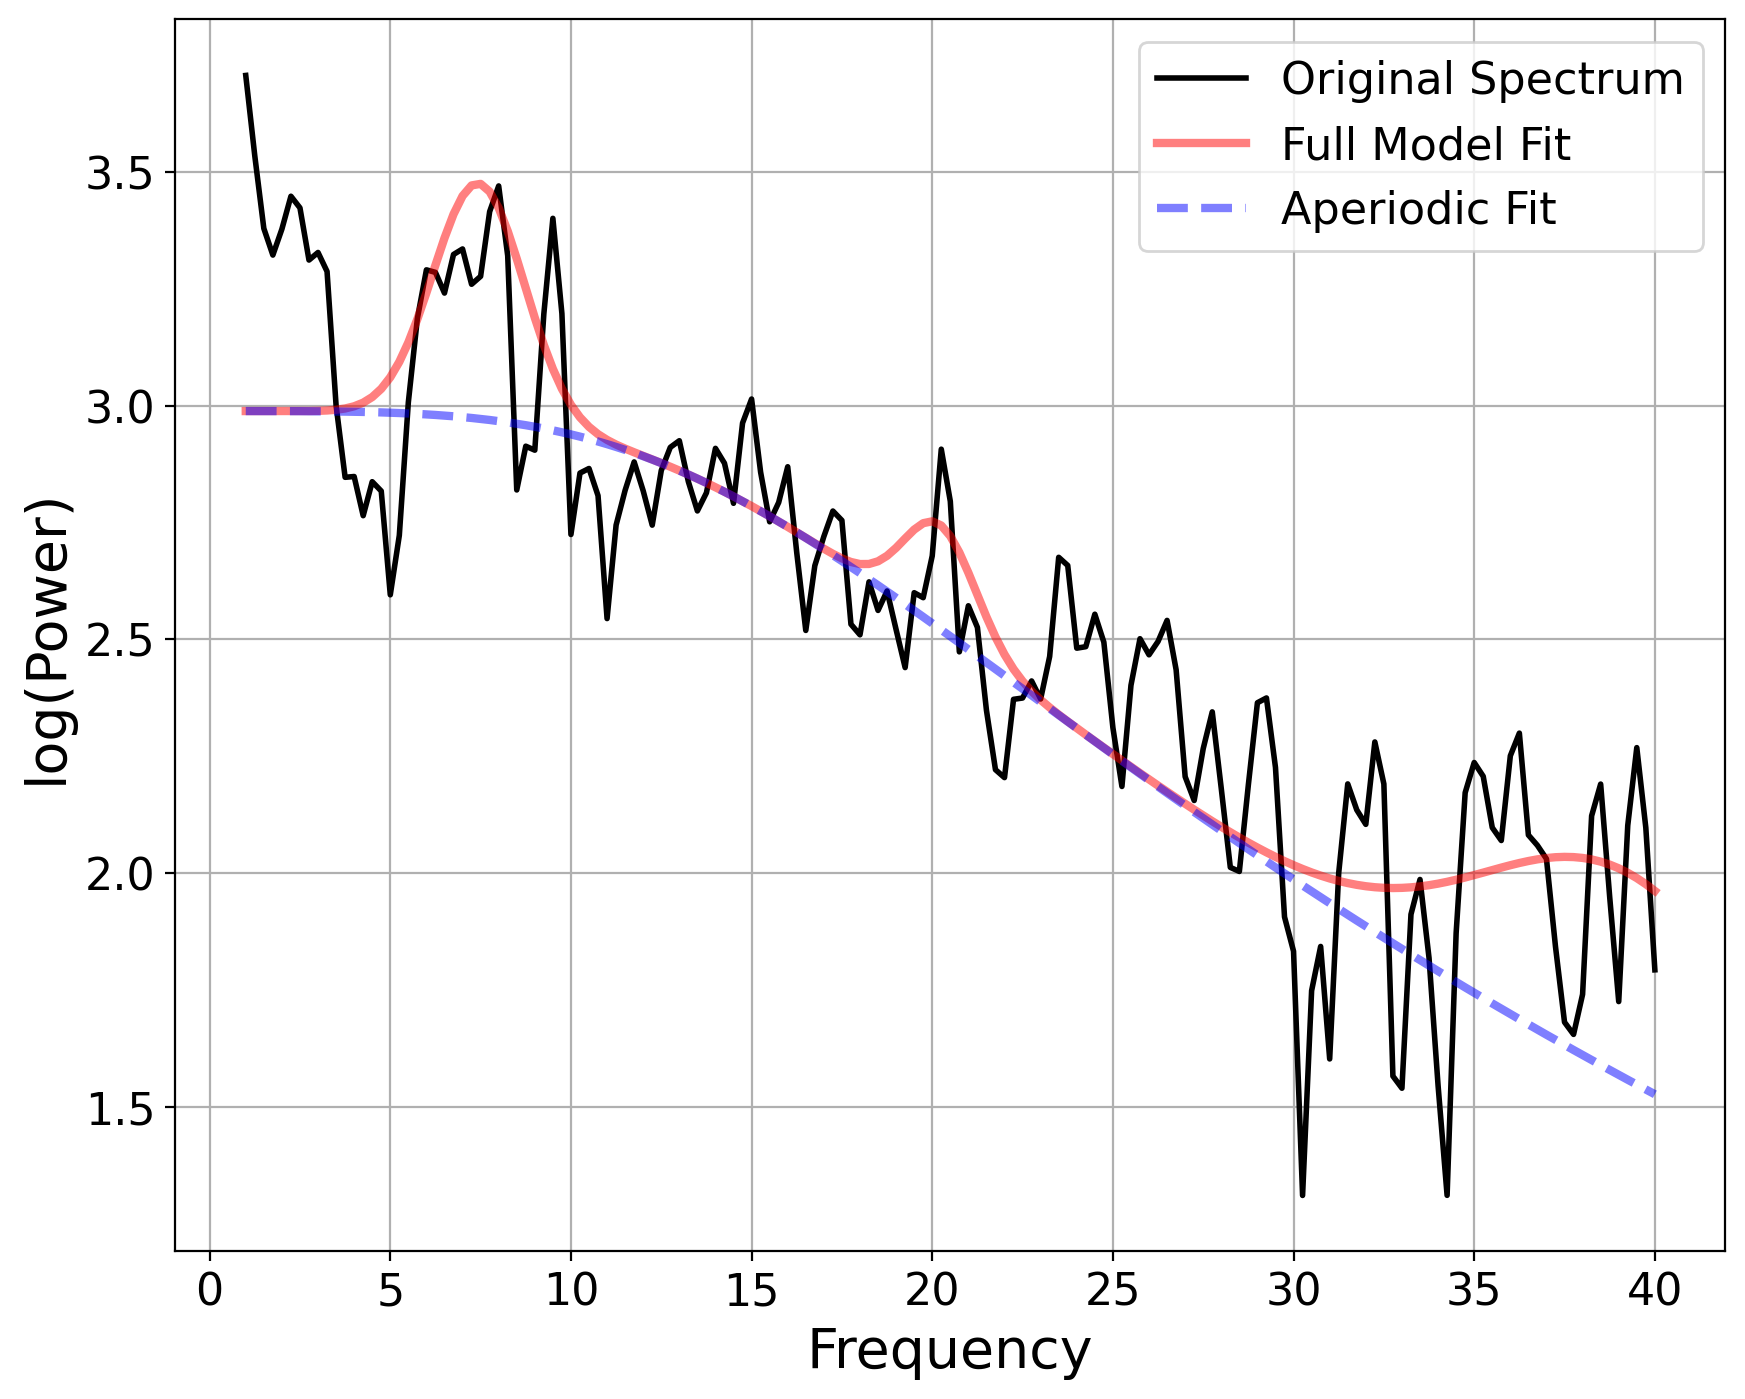

In [16]:
trial_subsets_model = FOOOF(**specparam_sets)
trial_subsets_model.fit(f, np.abs(p), freq_range=[1,40])
trial_subsets_model.report()

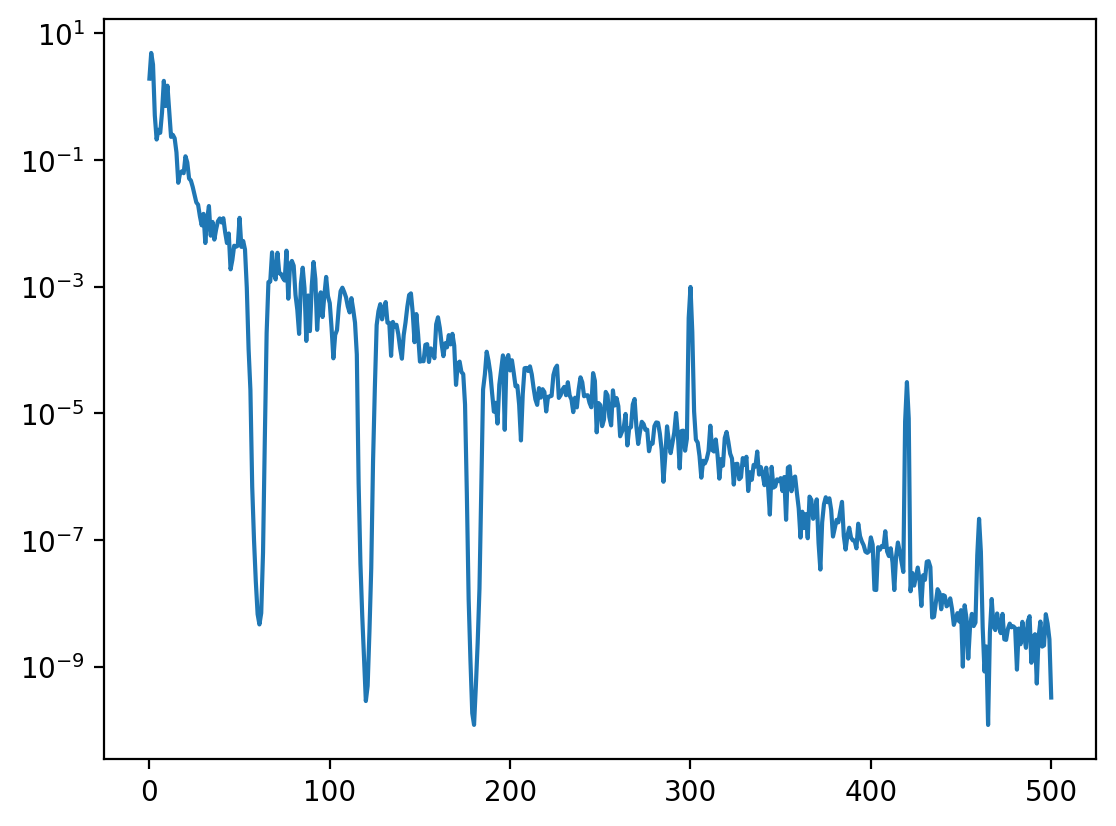

In [17]:
fW,pW = spectral.compute_spectrum(ex, fs, method='welch', avg_type='median')
plt.semilogy(fW,pW)

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                        The model was run on the frequency range 1 - 40 Hz                        
                                 Frequency Resolution is 1.00 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset, knee, exponent):                           
                                      1.3921, 9.1244, 2.1321                                      
                                                                                                  
                                       1 peaks were found:                                        
          

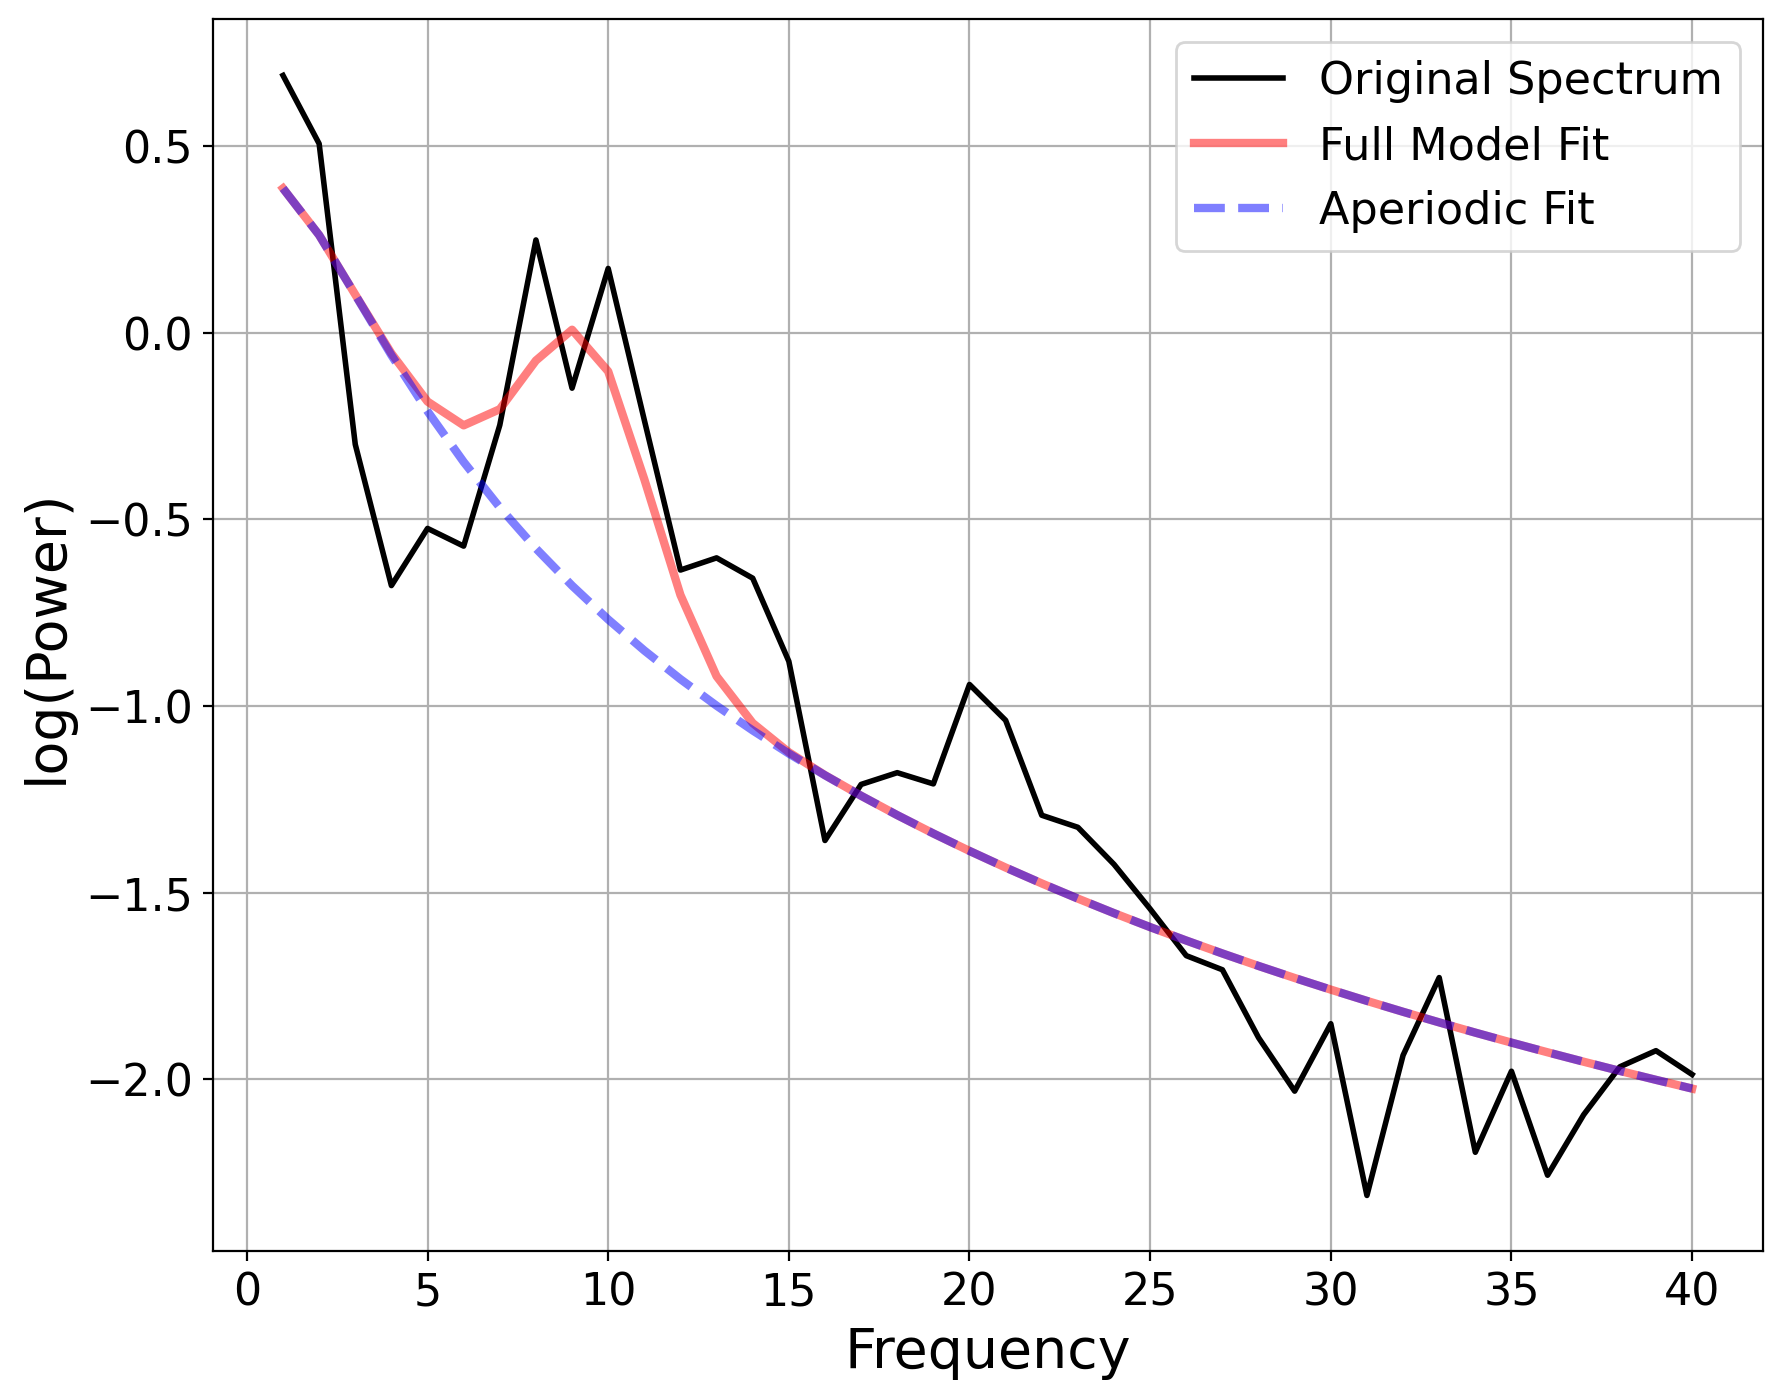

In [18]:
trial_subsets_model = FOOOF(**specparam_sets)
trial_subsets_model.fit(fW, pW, freq_range=[1,40])
trial_subsets_model.report()

In [19]:
np.arange(0, 4000, (1000-999))

array([   0,    1,    2, ..., 3997, 3998, 3999])

The raw timeseries shows a distinct event-related voltage fluctuation-- and maybe some interesting spectral changes?? 
Just based on visual inspection, it appears there may be a change from faster to slower oscillatory activity before and after the stimulus.
Let's calculate the power spectra as it morphs over the course of this trial

Now we have an array of shape n_events x n_times

Let's construct another function that averages across these events to get an ERP over the whole event time period, and drags our time window across the ERP in the specified timesteps to generate aperiodic fits at every point. 

In [31]:
def fft_windowed(sig, fs, zero_padding=0, window='hann'):
    if zero_padding:
        sig = np.hstack((np.zeros(padding),sig,np.zeros(padding)))

    assert window in ['hann'], "A valid window function must be specified"
    if window =='hann':
        window_func = hann(len(sig))
    # may add support for other window types
    
    convolved = window_func*sig
    p = np.abs(rfft(convolved))
    f = rfftfreq(len(sig), d= (1/fs))

    return f,p

def dynamic_fooof_fits(data_matrix, times, event_range, fs, window_length, t_overlap, freq_range, specparam_settings, spectral_settings, average_trials=1, report=1):
    """Take an input 2d matrix of windowed trials, and a window of a certain amount of time,
      and slide the window across the data, calculating a PSD and FOOOFGroup fit for each window.
    
    Parameters
    ----------
    data_matrix : array-like 2d
        Voltage time series for every trial
    times : array-like 1d
        The times (in ms) that each trial is event-locked around
    event_range: tuple of integers
        The start and end time of the data (-N to +N ms around the event time of 0)
    fs : float
        Data sampling rate (Hz)
    window_length : int
        Amount of time (in ms) per each window that will be slid across the data
    t_overlap : int
        How much overlap (in ms) desired between successive sliding windows. The timestep between windows is determined by (-len(signal)-t_overlap)
    freq_range : list of two integers
        Low and high range of frequency values to fit (in Hz)
    specparam_settings : dictionary
        FOOOFGroup setting kwargs
    spectral_settings : dictionary
        The arguments for customizing the methods used by fft_windowed()
        (besides the data and sampling frequency, which are specified differently)
    average_trials :  boolean
        whether to average across trials prior to generating power spectrum. If
        average_trials is False, the PSD and FOOOF fit will be calculated over every window 
        of every trial
    report : boolean
        whether to output the FOOOFGroup report of the power spectrum model fit. In the case that trials
        are not averaged, this outputs once per window slide.

    Returns
    -------
    time_steps : list of tuples
        Each tuple gives the start and end time of each window, which overlap with each for t_overlap time
    freqs : array-like 1d
        The set of frequencies generated by calculation of the power spectrum (and those fed into FOOOF)
    psds : list of arrays
        The raw power spectra output by calculation over each window across each trial
        If average_trials = True, this list will only be length 1, where the shape of the first elements is (n_windows, n_freqs)
        If average_trials = False, this list will be length equal to the number of windows slid over the data, and each element will be shape (n_trials, n_freqs) 
    fooof_groups_out : list of FOOOFGroup objects
        The FOOOFGroup object calculated over n_windows, or n_trials (depending on whether average_trials is T or F)
        If average_trials = True, the FOOOFGroup will be given an array shaped (n_windows, n_freqs). The resultant list is length of 1.
        If average_trials = False, the FOOOFGroup will be given an array shape (n_trials, n_freqs), and once per window. The resultant lsit will be length (n_windows). 

    
    """

    # get the start of each time window
    time_steps = np.arange(event_range[0], event_range[1], (window_length-t_overlap))
    # get the start and end of each time window, if it fits within the whole signal length
    time_steps = [(t, t+window_length) for t in time_steps if (t+window_length <= event_range[1])]

    # for each time step, extract the data of that time range out for every trial and average across trials if it is specified by user
    trial_subsets = np.zeros((len(time_steps), data_matrix.shape[0], int((window_length/1000)*fs))) # shape n_time steps, n events, n samples
    #print(trial_subsets.shape)
    for i, win in enumerate(time_steps):
        #print(win)
        subset_data = data_matrix[:, ((times>=win[0]) & (times<win[1]))] # should be shape n events, n samples (in this time window)
        trial_subsets[i,:,:] = subset_data

    fooof_groups_out = []
    psds = []
    if average_trials:

        # Compute power spectrum -- takes data in 2D array
        for i in range(len(time_steps)):
            # freq, psd = spectral.compute_spectrum(trial_subsets[i,:,:], fs=fs, **spectral_settings)
            for j in range(data_matrix.shape[0]):
                freq, psd_singleTr = fft_windowed(sig=trial_subsets[i,j,:], fs=fs, **spectral_settings)
                
                if (i == 0) and (j==0):
                    psd = np.zeros((len(time_steps),data_matrix.shape[0], len(freq)))

                psd[i,j,:] = psd_singleTr

        psd_tr_avg = psd.mean(axis=1) # averaging over trials to yield shape (n time windows, n freqs)
       
        trial_subsets_model = FOOOFGroup(**specparam_settings)
        trial_subsets_model.fit(freq, psd_tr_avg, freq_range=freq_range)
        if report:
            trial_subsets_model.report()
        fooof_groups_out.append(trial_subsets_model)
        psds.append(psd_tr_avg)
    else:
        # if we're not averaging across trial, we want to loop through every timestep and calculate the PSD and FOOOF on each set of trials for every timestep
        # this may take a long while depending on how many trials and how many timesteps you have (because it will run [n time steps X n trials] times)
        for i in range(len(time_steps)):
            # # Compute power spectrum -- takes data in 2D array
            # data_this_win = trial_subsets[i,:,:]
            # freq, psd = spectral.compute_spectrum(data_this_win, fs=fs, **spectral_settings)
            for j in range(data_matrix.shape[0]): # loop through trials
                freq, psd_singleTr = fft_windowed(sig=trial_subsets[i,j,:], fs=fs, **spectral_settings)
                
                if (j==0):
                    psd = np.zeros((data_matrix.shape[0], len(freq)))

                psd[j,:] = psd_singleTr
                # psd should be shape (n trials, n freqs)
        
            trial_subsets_model = FOOOFGroup(**specparam_settings)
            trial_subsets_model.fit(freq, psd, freq_range=freq_range)
            if report:
                trial_subsets_model.report()
            fooof_groups_out.append(trial_subsets_model)
            psds.append(psd)
                         

    return time_steps, freq, psds, fooof_groups_out

def get_alphas_pw(peak_params, n_wins, alphas_bounds=(7,14)):
    alphas_pws = []
    
    for win in range(n_wins):
        for pms in peak_params:
            if pms[-1] == win:
                if (pms[0] > alphas_bounds[0]) and (pms[0] < alphas_bounds[1]):
                    alphas_pws.append(pms[1])
    
    return alphas_pws

Time before and after stim: (-2000, 2000)
Window Overlap: 500
FOOOF settings: {'peak_width_limits': [2, 8], 'min_peak_height': 0.1, 'aperiodic_mode': 'knee'}
Window Length: 1000


Running FOOOFGroup across 7 power spectra.
Running FOOOFGroup across 7 power spectra.


c:\Users\dillc\anaconda3\envs\aperiodicMethods\Lib\site-packages\fooof\objs\group.py:378: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  out = np.array([np.insert(getattr(data, name), 3, index, axis=1)


                                                                                                  
                                       FOOOF - GROUP RESULTS                                      
                                                                                                  
                             Number of power spectra in the Group: 7                              
                                                                                                  
                        The model was run on the frequency range 2 - 40 Hz                        
                                 Frequency Resolution is 1.00 Hz                                  
                                                                                                  
                               Power spectra were fit with a knee.                                
                                                                                                  
          

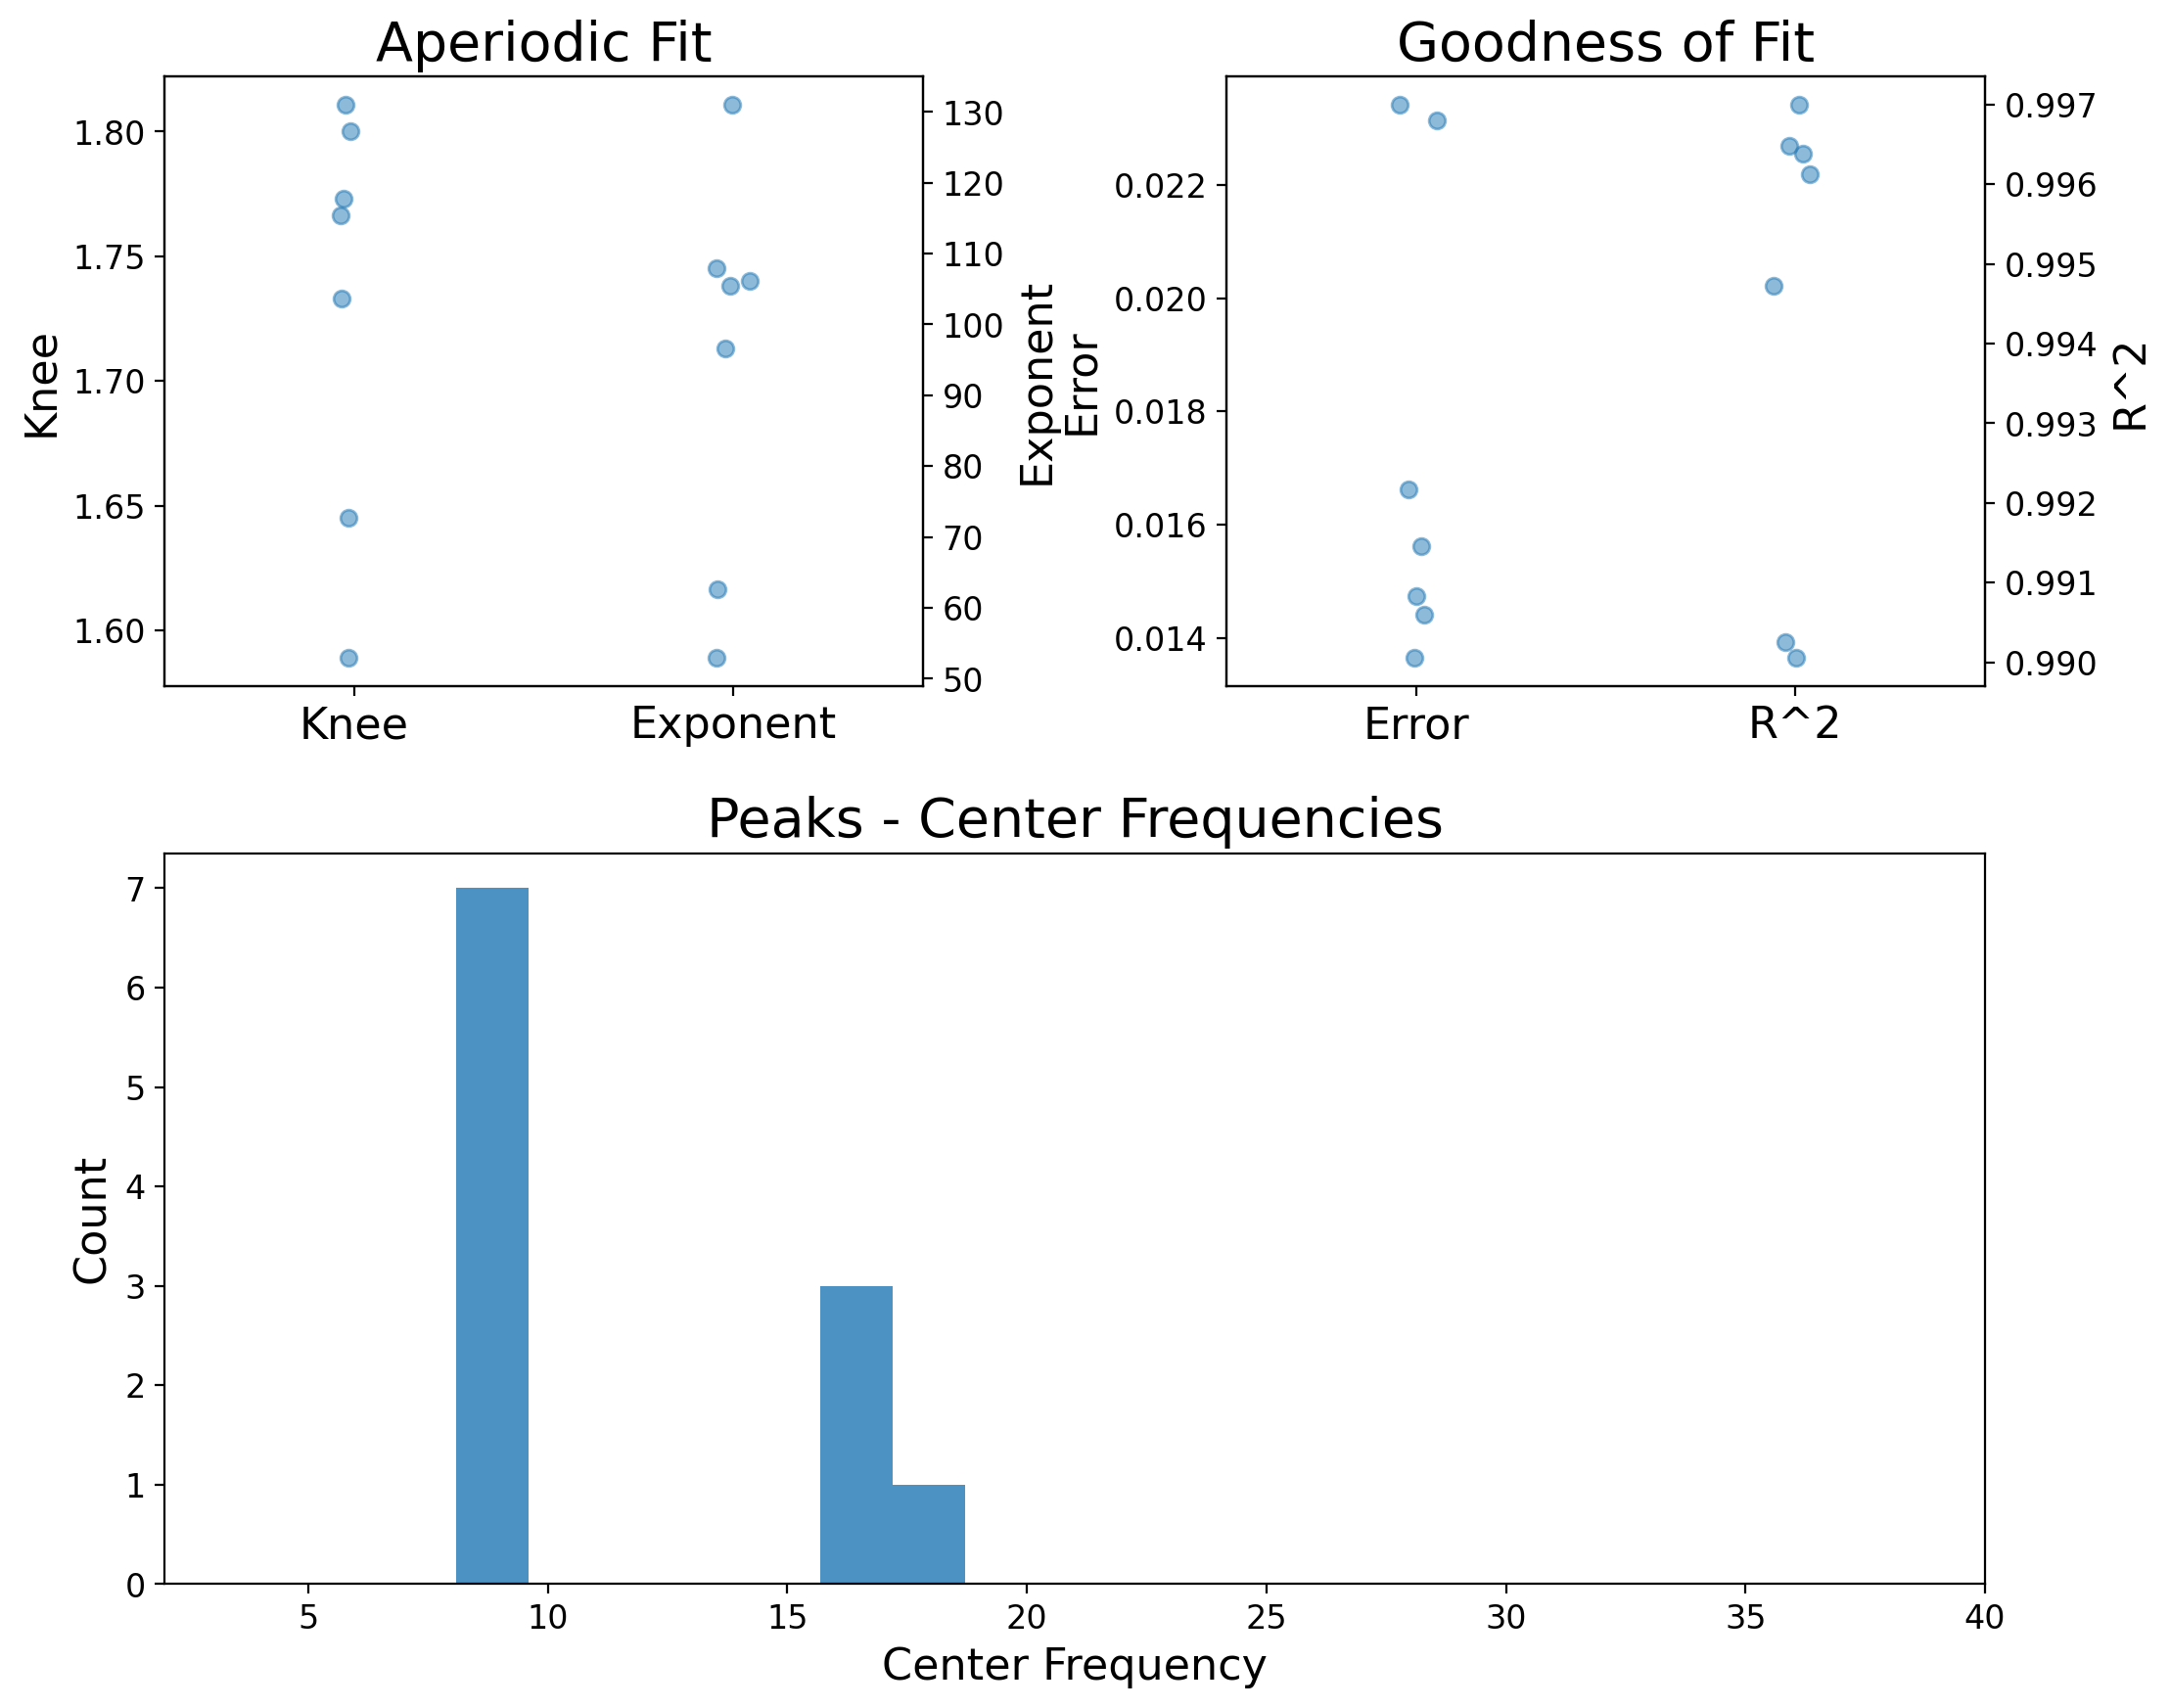

In [32]:
print("Time before and after stim: "+str(time_around_event))
print("Window Overlap: "+str(t_overlap))
print("FOOOF settings: "+str(specparam_sets))
print("Window Length: "+str(len_win))
print('\n')
ts, freqs, powers_list, groups_list = dynamic_fooof_fits(data_matrix=event_related_matrix, times=event_times, event_range=time_around_event, fs=fs, window_length=len_win, t_overlap=t_overlap, 
                              freq_range=[2,40], specparam_settings=specparam_sets, spectral_settings={'zero_padding':0,'window':'hann'},
                              average_trials=1, report=1)

Let's inspect the FOOOF fit of the first 1-second window of data over our trial-averaged ERP!

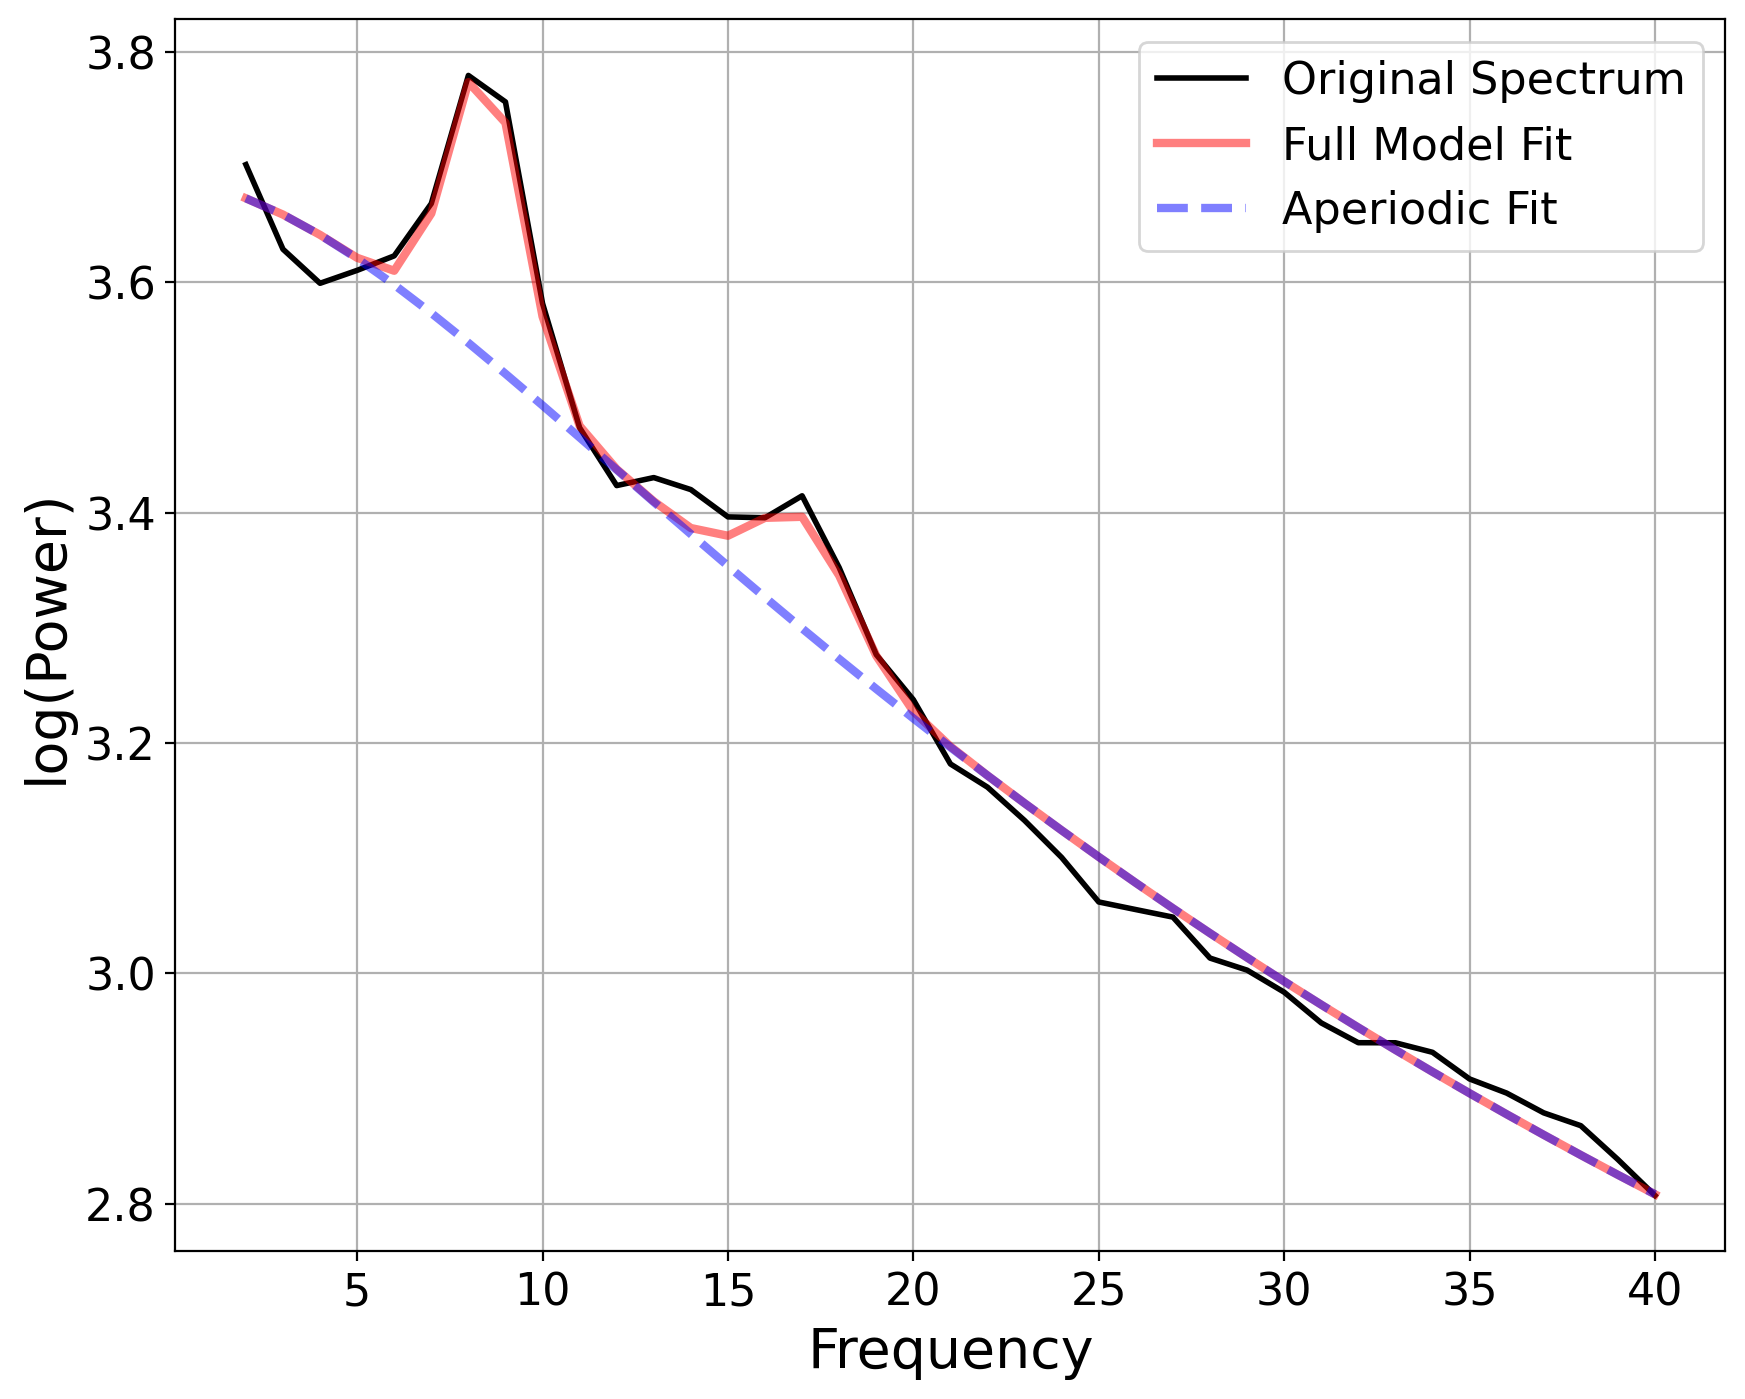

In [33]:
groups_list[0].get_fooof(0).plot()

The aperiodic fit here seems to be more or less captured-- though the overall noise of this spectrum is relatively low since we've averaged across the Power Spectra of so many trials!
Let's inspect whether the aperiodic estimate changes at all over the course of the trial by comparing the results of each sliding window:

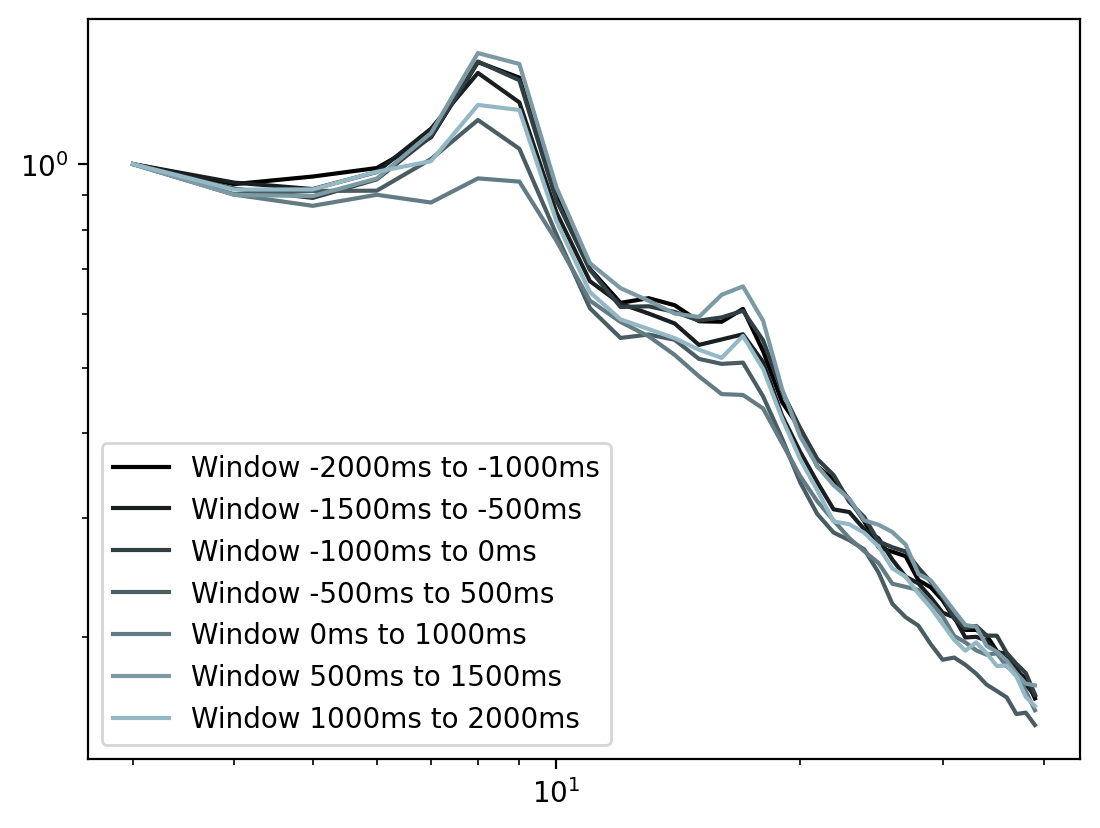

In [34]:
# helper function for our color coding
def colorFader(c1,c2,mix=0): #fade (linear interpolate) from color c1 (at mix=0) to c2 (mix=1)
    c1=np.array(matplotlib.colors.to_rgb(c1))
    c2=np.array(matplotlib.colors.to_rgb(c2))
    return matplotlib.colors.to_hex((1-mix)*c1 + mix*c2)

raw_spec = powers_list[0]
for i in range(len(ts)):
    color = colorFader('black','lightblue',i/len(ts))
    
    # crop our spectra to the range of freqs of interest
    f = freqs[(freqs>2)&(freqs<40)]
    win_spec = raw_spec[i,:][(freqs>2)&(freqs<40)]
    # align each spec to offset so that it's easier to compare changes in slope and oscillations
    plt.loglog(f, win_spec/win_spec[0], color=color, label='Window '+str(ts[i][0])+"ms to "+str(ts[i][1])+"ms")
plt.legend()
plt.show()

Let's plot the evolution of our parameters

[105.48931581431904, 106.07672272362075, 96.6713221729636, 107.99164629868079, 52.89914365060287, 131.04631949187342, 62.58876980182246]


Text(0, 0.5, 'Aperiodic Exponent')

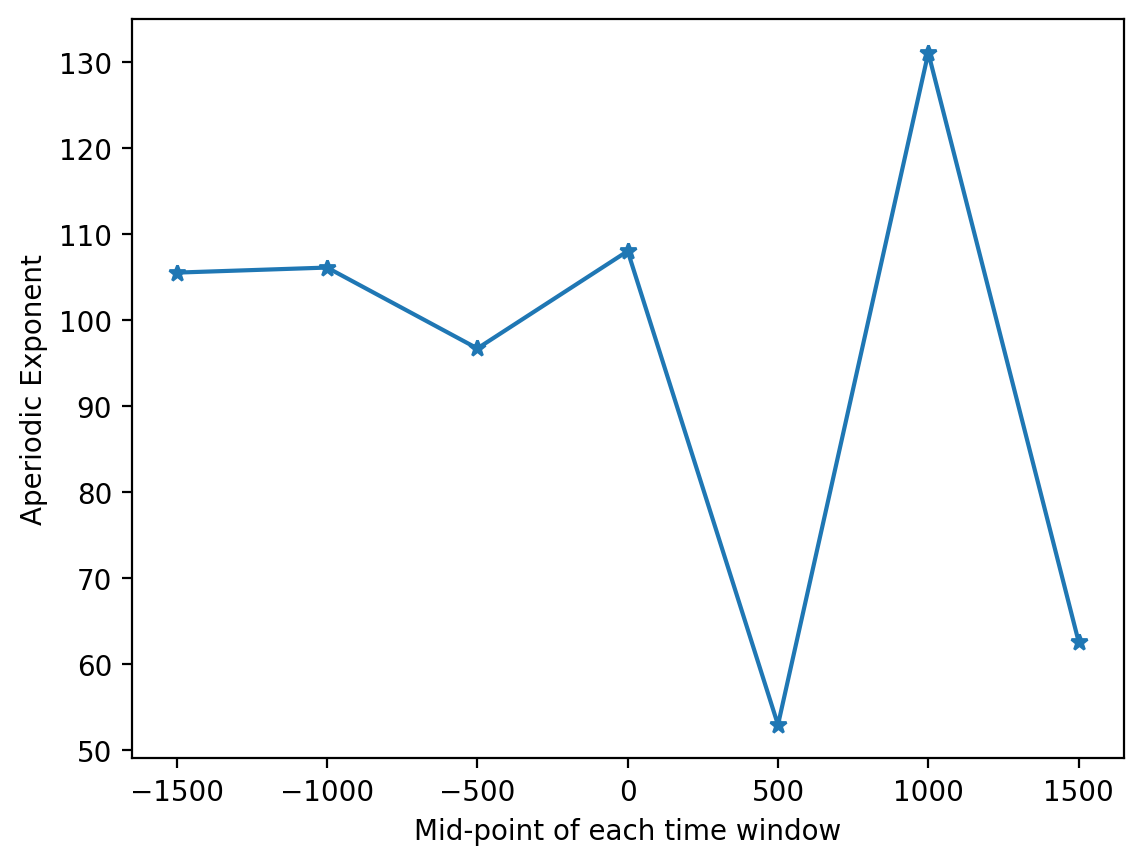

In [35]:
aper_params = groups_list[0].get_params('aperiodic_params')
exps = [k[1] for k in aper_params]
print(exps)
plt.plot([((t[0]+t[1])/2) for t in ts],exps, marker='*')
plt.xlabel('Mid-point of each time window')
plt.ylabel('Aperiodic Exponent')

[0.22639354867047157, 0.23004479993729143, 0.23936874199635705, 0.19080505111134727, 0.12317218990197087, 0.24961811455226046, 0.19779079493665463]


Text(0, 0.5, 'Alpha Power')

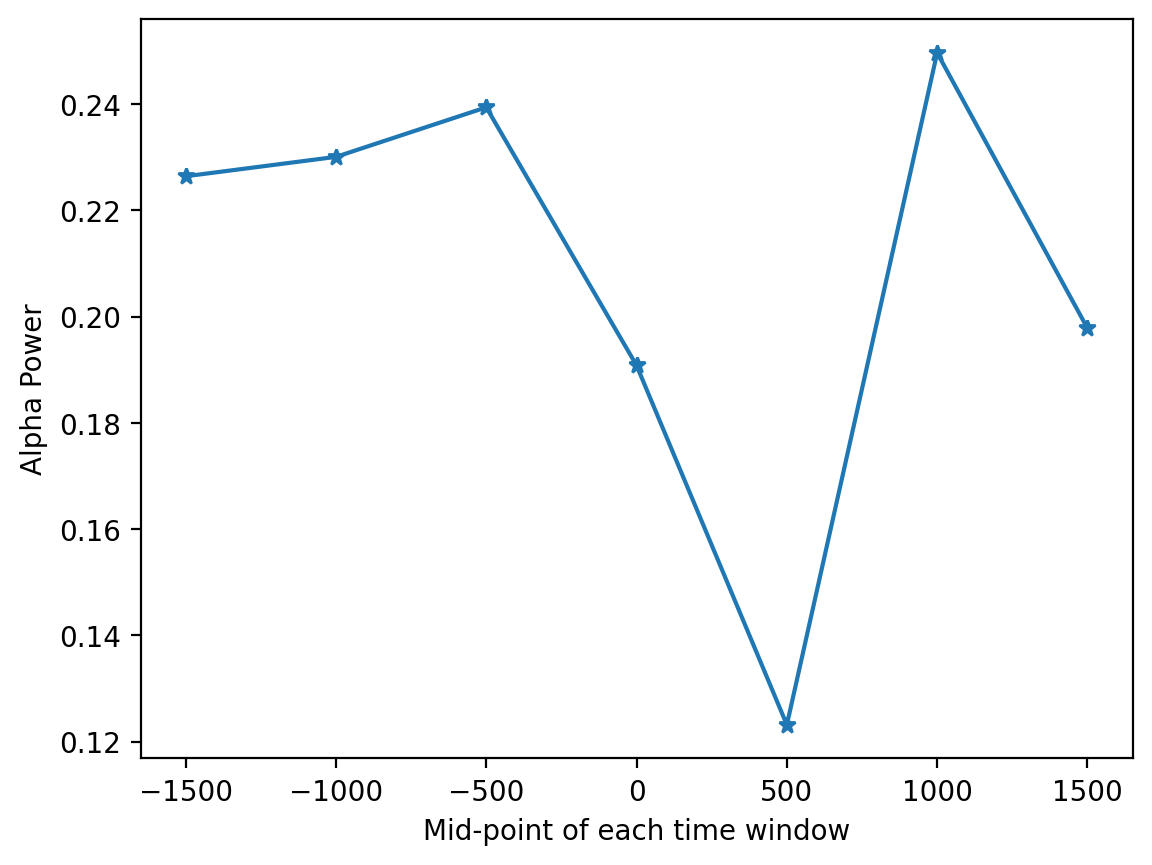

In [36]:
peak_params = groups_list[0].get_params('peak_params')
# Get the alpha peak powers
peaks = get_alphas_pw(peak_params, n_wins=len(ts))#[k[1] for k in peak_params[::2]]
print(peaks)
plt.plot([((t[0]+t[1])/2) for t in ts],peaks, marker='*')
plt.xlabel('Mid-point of each time window')
plt.ylabel('Alpha Power')


-----------------------------------------------------------------------------------------------------------

This is a great exercise in examining the shifts in aperiodic and periodic activity over time. However, to do so we averaged over single trials. This has the benefit of making our aperiodic model fitting less corrupted by the noise introduced by variation between trials. But what if you wanted to examine the relationship between continuous values of something like single-trial reaction times, and the pre-stimulus aperiodic exponent? Short of binning data such that you'd be able to trial-average PSDs before FOOOFing them, how would you do this?

In the next section we explore how to generate FOOOF fits of single trials, conduct data QA to eliminate trials with nonsenical and noisy fits, and compile the single-trial aperiodic parameters. 

### Single-trial fits

In [ ]:
len_win = 1000

print("Time before and after stim: "+str(time_around_event))
print("Window Overlap: "+str(t_overlap))
print("FOOOF settings: "+str(specparam_sets))
print("Window Length: "+str(len_win))
print('\n')
ts, freqs, powers_list, groups_list = dynamic_fooof_fits(data_matrix=event_related_matrix, times=event_times, event_range=time_around_event, fs=fs, window_length=len_win, t_overlap=t_overlap, 
                              freq_range=[1,40], specparam_settings=specparam_sets, spectral_settings={'zero_padding':500},
                              average_trials=0, report=0)
print(ts)

In [42]:
# When we're not averaging over trials, our groups_list and powers_list each contain elements for each time window. 
# Groups_list contains FOOOFGroup objects that contain FOOOF model fits for every trial, and powers_list is a list of raw PSDs, one for each window and shaped (n_trials, n_freqs)
print(ts)
print(len(ts))
print(len(groups_list))
print(len(powers_list))
print(powers_list[0].shape)

[(-2000, -1000), (-1500, -500), (-1000, 0), (-500, 500), (0, 1000), (500, 1500), (1000, 2000)]
7
7
7
(497, 1001)


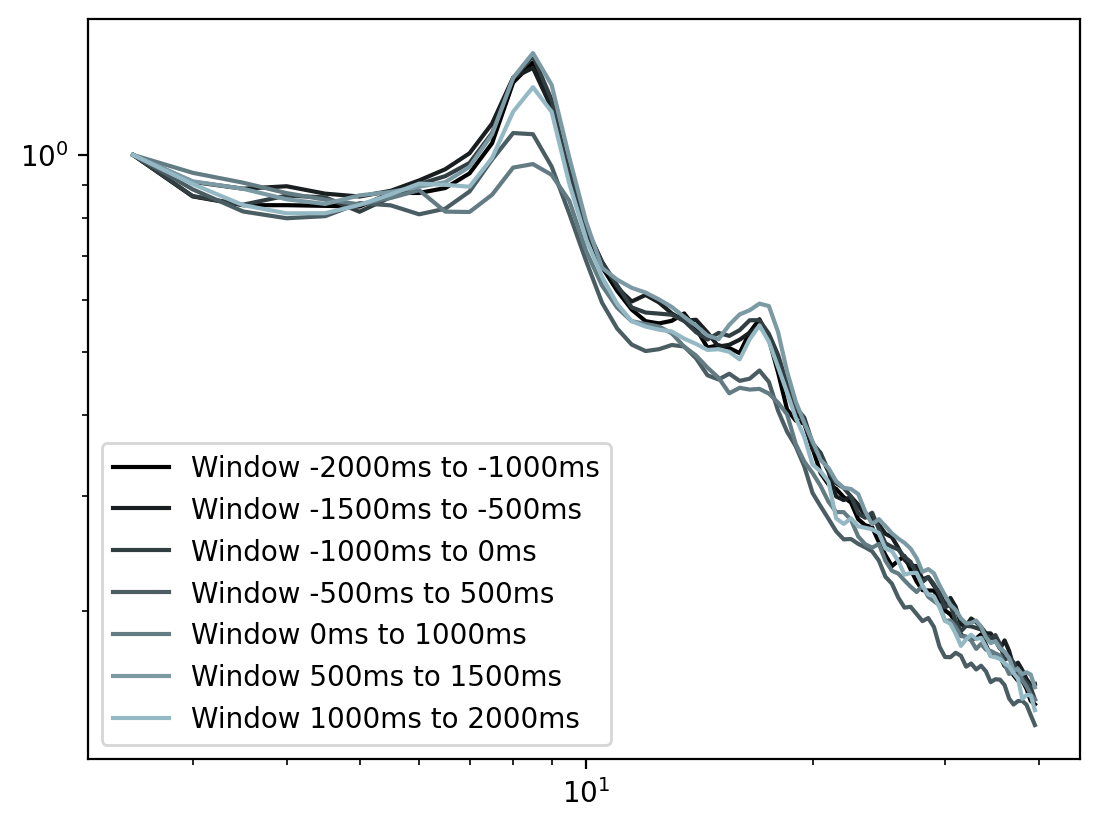

In [45]:
# examine the first trial's raw PSDs for each sliding window
for i in range(len(ts)):
    color = colorFader('black','lightblue',i/len(ts))
    
    # crop our spectra to the range of freqs of interest
    f = freqs[(freqs>2)&(freqs<40)]
    win_spec = powers_list[i].mean(axis=0)[(freqs>2)&(freqs<40)]
    # align each spec to offset so that it's easier to compare changes in slope and oscillations
    plt.loglog(f, win_spec/win_spec[0], color=color, label='Window '+str(ts[i][0])+"ms to "+str(ts[i][1])+"ms")
plt.legend()
plt.show()

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                        The model was run on the frequency range 1 - 40 Hz                        
                                 Frequency Resolution is 0.50 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset, knee, exponent):                           
                                     2.4946, -0.9329, 0.0960                                      
                                                                                                  
                                       3 peaks were found:                                        
          

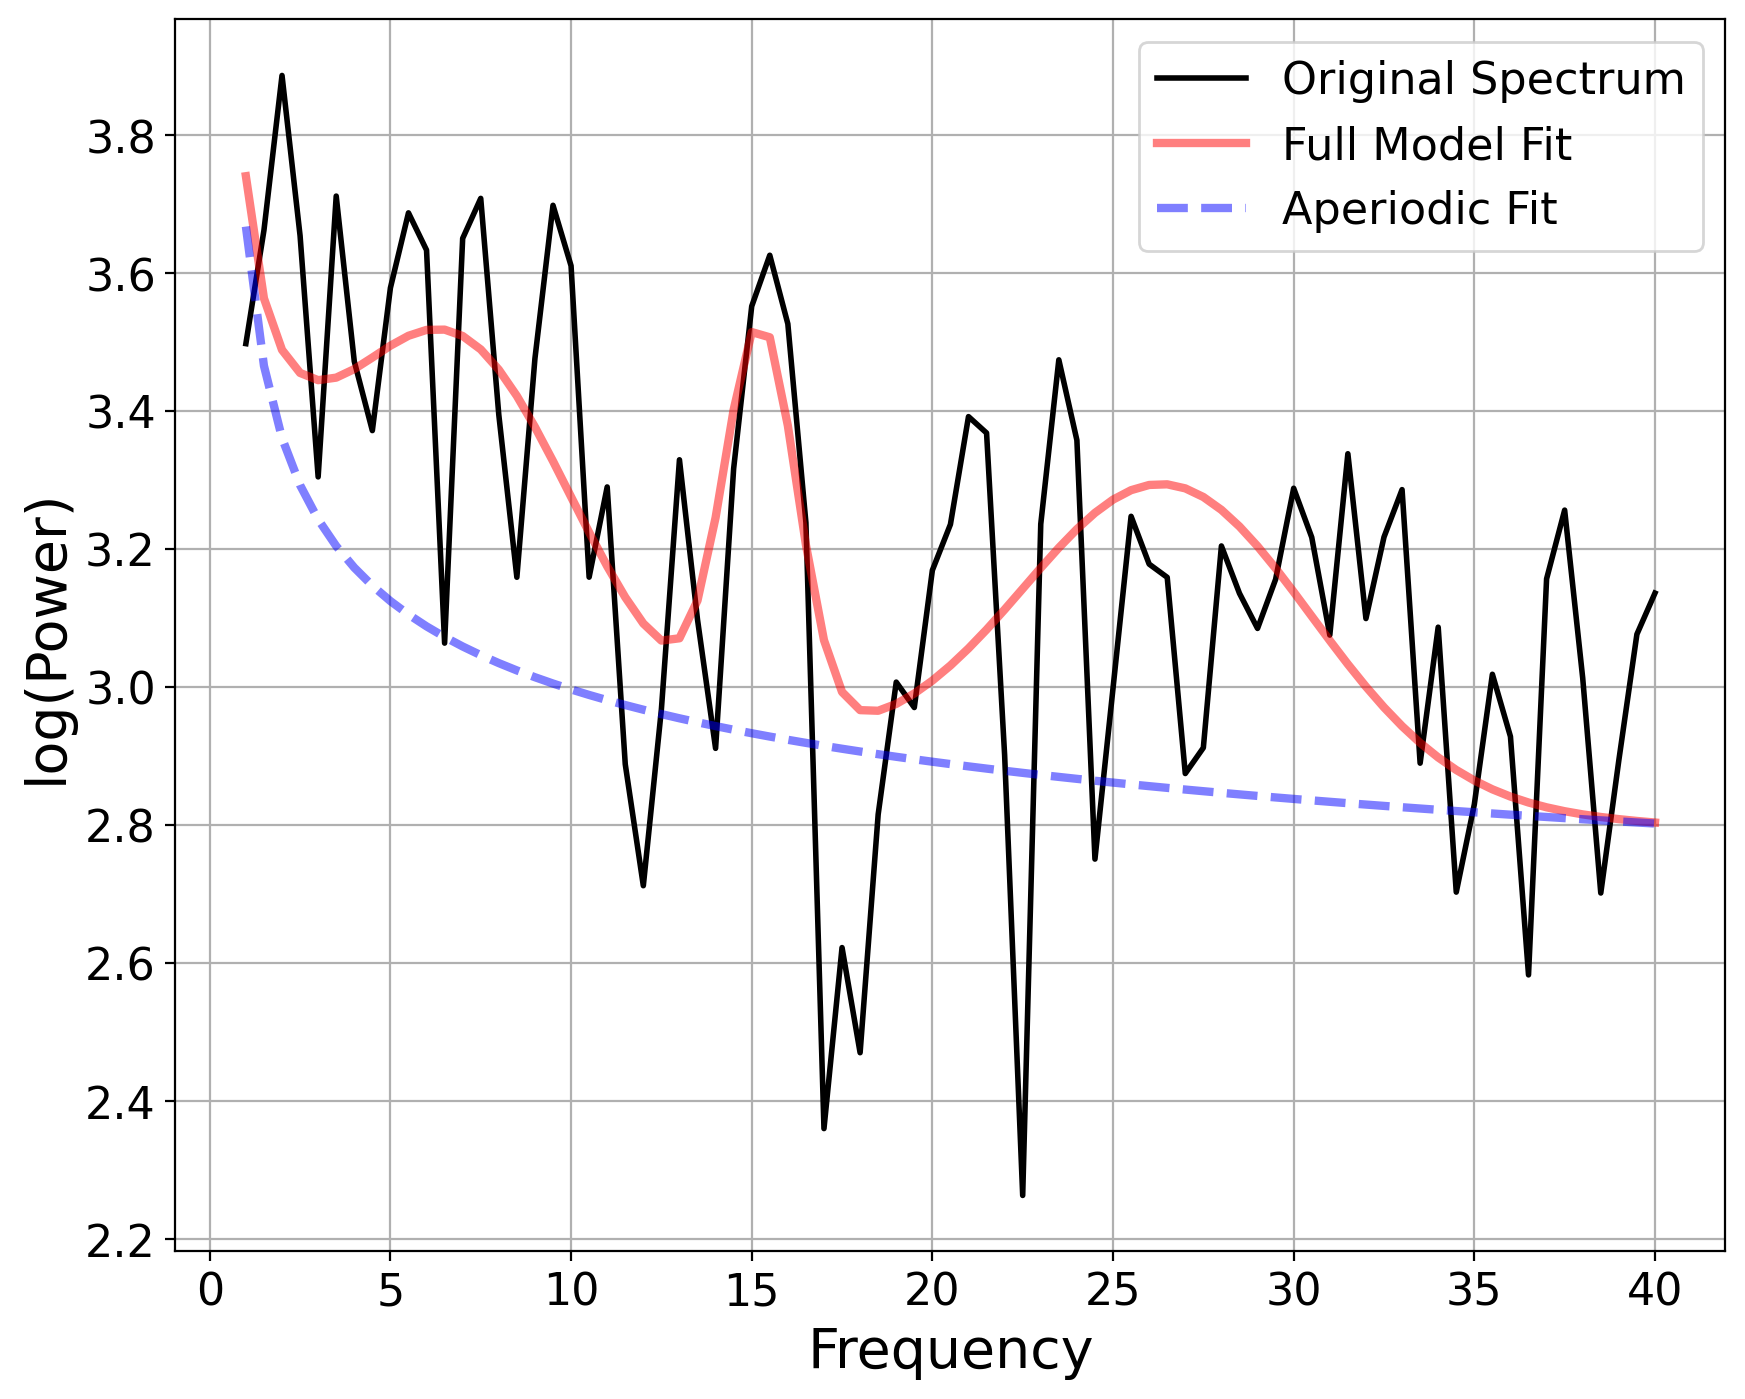

In [43]:
# Examine the first single-trial fit of the first sliding window
groups_list[0].get_fooof(0).report()

Running FOOOFGroup across 497 power spectra.
Model fitting was unsuccessful.


c:\Users\dillc\anaconda3\envs\aperiodicMethods\Lib\site-packages\fooof\core\funcs.py:67: RuntimeWarning: invalid value encountered in log10
  ys = ys + offset - np.log10(knee + xs**exp)
c:\Users\dillc\anaconda3\envs\aperiodicMethods\Lib\site-packages\fooof\core\funcs.py:67: RuntimeWarning: invalid value encountered in log10
  ys = ys + offset - np.log10(knee + xs**exp)
c:\Users\dillc\anaconda3\envs\aperiodicMethods\Lib\site-packages\fooof\core\funcs.py:67: RuntimeWarning: invalid value encountered in log10
  ys = ys + offset - np.log10(knee + xs**exp)
c:\Users\dillc\anaconda3\envs\aperiodicMethods\Lib\site-packages\fooof\core\funcs.py:67: RuntimeWarning: invalid value encountered in log10
  ys = ys + offset - np.log10(knee + xs**exp)
c:\Users\dillc\anaconda3\envs\aperiodicMethods\Lib\site-packages\fooof\core\funcs.py:67: RuntimeWarning: invalid value encountered in log10
  ys = ys + offset - np.log10(knee + xs**exp)
c:\Users\dillc\anaconda3\envs\aperiodicMethods\Lib\site-packages\fooof

                                                                                                  
                                       FOOOF - GROUP RESULTS                                      
                                                                                                  
                            Number of power spectra in the Group: 497                             
                                  1 power spectra failed to fit                                   
                                                                                                  
                        The model was run on the frequency range 1 - 40 Hz                        
                                 Frequency Resolution is 0.50 Hz                                  
                                                                                                  
                               Power spectra were fit with a knee.                                
          

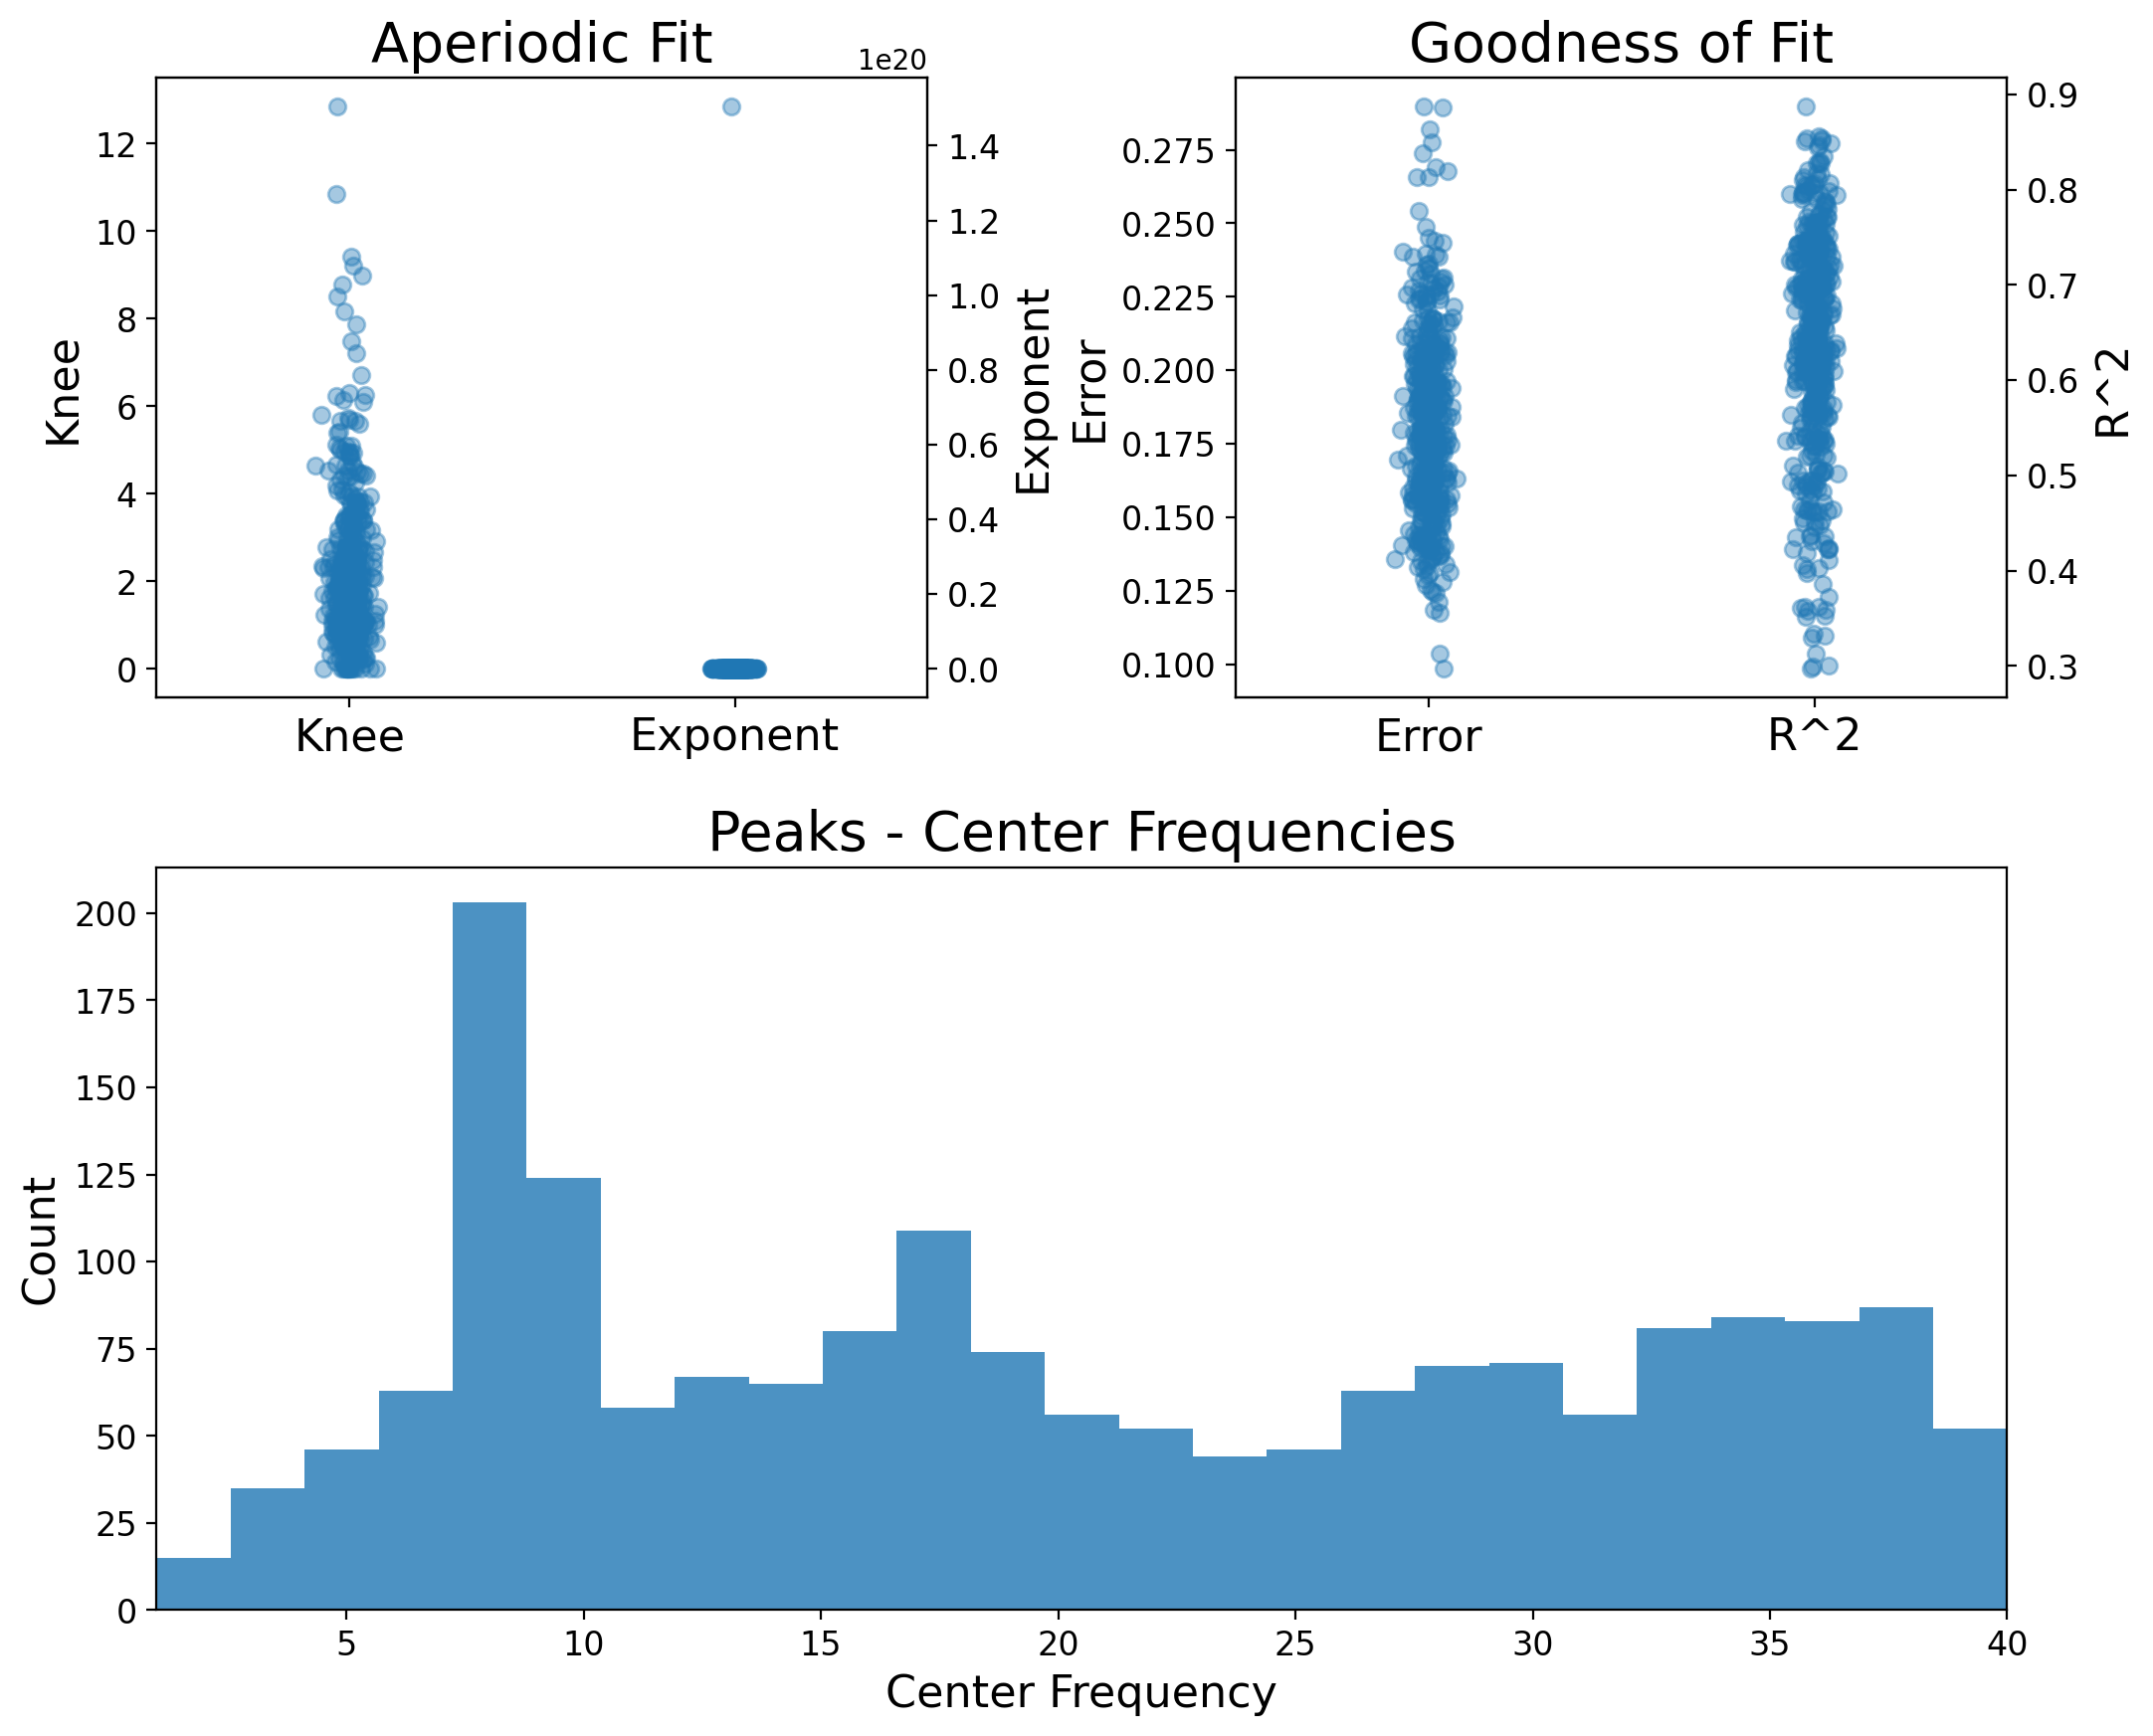

In [69]:
groups_list[0].report()

In [70]:
# # examine the first trial's raw PSDs for each sliding window
# for i in range(len(ts)):
#     color = colorFader('black','lightblue',i/len(ts))
    
#     # crop our spectra to the range of freqs of interest
#     f = freqs[(freqs>2)&(freqs<40)]
#     win_spec = powers_list[i][0,:][(freqs>2)&(freqs<40)]
#     # align each spec to offset so that it's easier to compare changes in slope and oscillations
#     plt.loglog(f, win_spec/win_spec[0], color=color, label='Window '+str(ts[i][0])+"ms to "+str(ts[i][1])+"ms")
# plt.legend()
# plt.show()

[2.0885459297781885, 1.8789610581529392, 2.0216288117275556, 1.9219808593031187, 1.7508773418540253, 2.077580772381196, 2.0922811956650116]


Text(0, 0.5, 'Aperiodic Exponent')

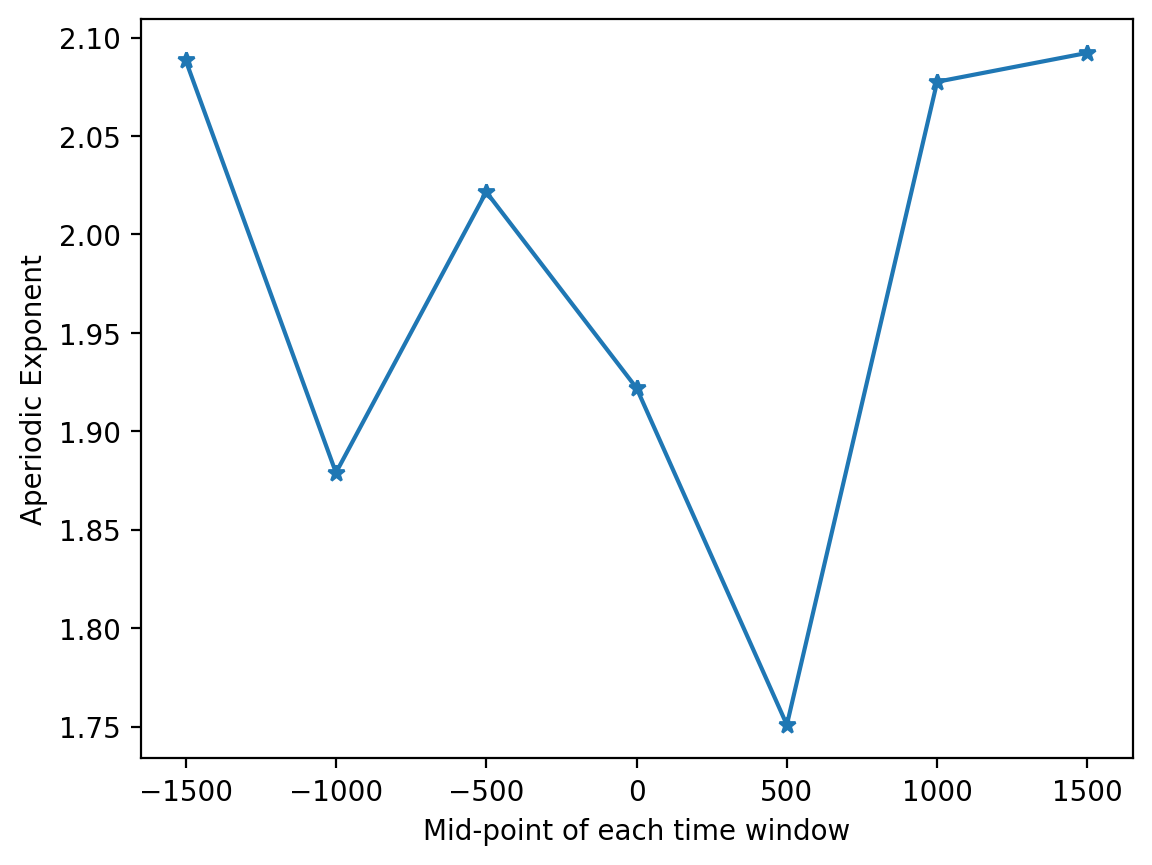

In [67]:
exps=[]
for i in range(len(ts)):
    aper_params = groups_list[i].get_params('aperiodic_params',col='exponent')
    aper_params = aper_params[np.isfinite(aper_params)]
    exps.append(aper_params.mean(axis=0))
print(exps)
plt.plot([((t[0]+t[1])/2) for t in ts],exps, marker='*')
plt.xlabel('Mid-point of each time window')
plt.ylabel('Aperiodic Exponent')

Exponent shows similar pattern but very different scale?

### Conclusion

<>